<a href="https://colab.research.google.com/github/davidlealo/sic_ai_2025_sept/blob/main/5_deep_learning/clase_35.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Introducción a TensorFlow para Deep Learning**

TensorFlow es una biblioteca de código abierto desarrollada por Google, diseñada para construir, entrenar y desplegar modelos de aprendizaje automático, con un enfoque especial en **redes neuronales profundas (deep neural networks, DNNs)**. Su flexibilidad permite desde implementaciones de bajo nivel (control total sobre operaciones y gradientes) hasta APIs de alto nivel (como Keras) que simplifican el desarrollo. En deep learning, TensorFlow destaca por:
- Manejo eficiente de tensores (datos multidimensionales).
- Soporte para entrenamiento en CPU, GPU y TPU.
- Integración con herramientas como TensorBoard para visualización.
- Capacidad para modelos complejos como CNNs, RNNs y transformers.

Desde TensorFlow 2.x (introducido en 2019 y mejorado con el tiempo), el modo **eager execution** es el predeterminado, permitiendo ejecutar operaciones de forma inmediata y facilitando la depuración. Sin embargo, también soporta el modo de grafos estáticos para optimización en producción.

---

### **Componentes clave de TensorFlow para Deep Learning**

1. **Tensores**:
   - Los tensores son las unidades básicas de datos en TensorFlow, similares a matrices o vectores multidimensionales.
   - Ejemplo: Una imagen de MNIST se representa como un tensor de forma `(28, 28, 1)` o `(784,)` cuando aplanada.
   - Se manipulan con operaciones como `tf.matmul` (multiplicación matricial) y `tf.add` (suma).

2. **Variables**:
   - Representan parámetros entrenables como pesos (`W`) y sesgos (`b`).
   - Se definen con `tf.Variable` y se actualizan durante el entrenamiento.
   - Ejemplo: `W1 = tf.Variable(tf.random.normal([784, 256]))`.

3. **GradientTape**:
   - Mecanismo para calcular gradientes automáticamente mediante retropropagación.
   - Útil para implementaciones personalizadas sin depender de optimizadores predefinidos.
   - Ejemplo: `with tf.GradientTape() as tape: ... gradients = tape.gradient(loss, [W1, b1])`.

4. **Optimizadores**:
   - Algoritmos como SGD (`tf.keras.optimizers.SGD`), Adam (`tf.keras.optimizers.Adam`) o RMSprop ajustan parámetros minimizando la pérdida.
   - En bajo nivel, puedes implementar SGD manualmente con momentum:
     \[
     v = \mu \cdot v - \eta \cdot \nabla L, \quad \theta = \theta + v
     \]

5. **Capas y modelos**:
   - Con Keras (`tf.keras.layers`), puedes apilar capas como `Dense`, `Conv2D`, o `LSTM`.
   - Sin Keras, defines operaciones manualmente (por ejemplo, `tf.matmul(x, W) + b`).

6. **Funciones de pérdida**:
   - Ejemplos: Entropía cruzada categórica (`tf.nn.softmax_cross_entropy_with_logits`) para clasificación, error cuadrático medio para regresión.
   - Se minimizan durante el entrenamiento.

7. **Datasets**:
   - `tf.data.Dataset` optimiza el manejo de datos, permitiendo cargar, preprocesar y alimentar lotes al modelo.
   - Ejemplo: `ds_train = ds_train.batch(32).prefetch(tf.data.AUTOTUNE)`.

8. **TensorBoard**:
   - Herramienta para visualizar métricas, grafos y pesos durante el entrenamiento.

---

### **Flujo de trabajo típico para Deep Learning con TensorFlow**

#### **1. Preparación de datos**
- **Carga**: Usa `tensorflow_datasets` (como MNIST) o carga datos personalizados.
- **Preprocesamiento**: Normaliza valores (por ejemplo, dividir por 255 para imágenes), aplane o redimensione datos, y convierta etiquetas a one-hot si es necesario.
- **Lotes**: Usa `tf.data.Dataset` para crear lotes y optimizar el flujo de datos.

#### **2. Definición del modelo**
- **Arquitectura**: Define capas (ocultas con activaciones como ReLU, salida con softmax para clasificación).
  - Sin Keras: Usa operaciones como `tf.matmul` y `tf.nn.relu`.
  - Con Keras: `model = tf.keras.Sequential([tf.keras.layers.Dense(256, activation='relu'), tf.keras.layers.Dense(10, activation='softmax')])`.
- **Parámetros**: Inicializa pesos y sesgos con `tf.Variable` o `tf.keras.layers` lo hace automáticamente.

#### **3. Entrenamiento**
- **Pérdida**: Define la función de pérdida (por ejemplo, entropía cruzada).
- **Optimizador**: Elige un optimizador (SGD, Adam) y configura la tasa de aprendizaje.
- **Bucle de entrenamiento**:
  - Forward pass: Calcula predicciones.
  - Calcular pérdida: Compara predicciones con etiquetas.
  - Backward pass: Calcula gradientes con `GradientTape`.
  - Actualizar parámetros: Aplica el optimizador.
- **Épocas**: Repite el proceso varias veces.

#### **4. Evaluación**
- Usa un conjunto de validación o prueba para medir precisión y pérdida.
- Ajusta hiperparámetros si es necesario.

#### **5. Despliegue (opcional)**
- Exporta el modelo con `tf.saved_model` para TensorFlow Serving o TensorFlow Lite.

---

### **Ejemplo detallado: Red neuronal profunda sin Keras**

A continuación, implementamos una red neuronal con una capa oculta para clasificar los 10 dígitos de MNIST usando TensorFlow sin Keras, destacando el uso de descenso del gradiente manual.

<xaiArtifact artifact_id="318faa5c-0bc0-4bf9-ad39-f231bfef1548" artifact_version_id="b5a4b754-7a08-453c-9612-058da716b621" title="deep_learning_mnist_no_keras_detailed.py" contentType="text/python">
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Paso 1: Preparación de datos
def preprocess_mnist(ds):
    ds = ds.map(lambda item: (tf.cast(item['image'], tf.float32) / 255.0,
                             tf.one_hot(item['label'], depth=10)))
    ds = ds.map(lambda image, label: (tf.reshape(image, (-1,)), label))
    return ds

ds_train, ds_test = tfds.load('mnist', split=['train', 'test'], as_supervised=False)
ds_train = preprocess_mnist(ds_train).cache().shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = preprocess_mnist(ds_test).batch(32).prefetch(tf.data.AUTOTUNE)

# Paso 2: Definir la arquitectura
n_input = 784
n_hidden = 256
n_output = 10

# Inicializar parámetros
W1 = tf.Variable(tf.random.normal([n_input, n_hidden], stddev=0.01))
b1 = tf.Variable(tf.zeros([n_hidden]))
W2 = tf.Variable(tf.random.normal([n_hidden, n_output], stddev=0.01))
b2 = tf.Variable(tf.zeros([n_output]))

# Paso 3: Definir el forward pass
def forward_pass(x):
    h = tf.nn.relu(tf.matmul(x, W1) + b1)  # Capa oculta con ReLU
    logits = tf.matmul(h, W2) + b2         # Capa de salida
    return tf.nn.softmax(logits)           # Probabilidades

# Paso 4: Definir pérdida y métricas
def compute_loss(y_true, y_pred):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=tf.math.log(y_pred + 1e-10)))

def compute_accuracy(y_true, y_pred):
    y_pred_labels = tf.argmax(y_pred, axis=1)
    y_true_labels = tf.argmax(y_true, axis=1)
    return tf.reduce_mean(tf.cast(tf.equal(y_pred_labels, y_true_labels), tf.float32))

# Paso 5: Implementar SGD con momentum
learning_rate = 0.01
momentum = 0.9
velocities = [tf.Variable(tf.zeros_like(w)) for w in [W1, b1, W2, b2]]

def train_step(x, y):
    with tf.GradientTape() as tape:
        predictions = forward_pass(x)
        loss = compute_loss(y, predictions)
    gradients = tape.gradient(loss, [W1, b1, W2, b2])
    for v, g, p in zip(velocities, gradients, [W1, b1, W2, b2]):
        v.assign(momentum * v - learning_rate * g)
        p.assign_add(v)
    return loss, compute_accuracy(y, predictions)

# Paso 6: Entrenamiento
epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    epoch_loss = 0.0
    epoch_acc = 0.0
    num_batches = 0
    
    for x_batch, y_batch in ds_train:
        loss, acc = train_step(x_batch, y_batch)
        epoch_loss += loss.numpy()
        epoch_acc += acc.numpy()
        num_batches += 1
    
    train_losses.append(epoch_loss / num_batches)
    train_accuracies.append(epoch_acc / num_batches)
    
    # Validación
    val_loss = 0.0
    val_acc = 0.0
    num_val_batches = 0
    for x_batch, y_batch in ds_test:
        predictions = forward_pass(x_batch)
        val_loss += compute_loss(y_batch, predictions).numpy()
        val_acc += compute_accuracy(y_batch, predictions).numpy()
        num_val_batches += 1
    
    val_losses.append(val_loss / num_val_batches)
    val_accuracies.append(val_acc / num_val_batches)
    
    print(f"Época {epoch+1}/{epochs}, Pérdida: {train_losses[-1]:.4f}, Precisión: {train_accuracies[-1]:.4f}, "
          f"Pérdida Val: {val_losses[-1]:.4f}, Precisión Val: {val_accuracies[-1]:.4f}")

# Paso 7: Evaluación final
test_loss = 0.0
test_acc = 0.0
num_test_batches = 0
for x_batch, y_batch in ds_test:
    predictions = forward_pass(x_batch)
    test_loss += compute_loss(y_batch, predictions).numpy()
    test_acc += compute_accuracy(y_batch, predictions).numpy()
    num_test_batches += 1
print(f"Precisión final en el conjunto de prueba: {test_acc / num_test_batches:.4f}")

# Paso 8: Visualización de predicciones
for x_batch, y_batch in ds_test.take(1):
    predictions = forward_pass(x_batch)
    y_pred = np.argmax(predictions, axis=1)

fig = plt.figure(figsize=(15, 6))
for i, (image, label, pred) in enumerate(zip(x_batch[:10], y_batch[:10], y_pred[:10])):
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(image.numpy().reshape(28, 28), cmap='gray_r')
    ax.set_title(f"Etiqueta: {np.argmax(label.numpy())}, Pred: {pred}", size=12)
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.show()

# Paso 9: Visualización de métricas
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Pérdida (entrenamiento)')
plt.plot(val_losses, label='Pérdida (validación)')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el entrenamiento')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Precisión (entrenamiento)')
plt.plot(val_accuracies, label='Precisión (validación)')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Precisión durante el entrenamiento')
plt.legend()
plt.tight_layout()
plt.show()

# Paso 10: Visualización de pesos
fig = plt.figure(figsize=(15, 6))
for i in range(min(10, n_hidden)):
    ax = fig.add_subplot(2, 5, i+1)
    weight_image = W1.numpy()[:, i].reshape(28, 28)
    ax.imshow(weight_image, cmap='coolwarm')
    ax.set_title(f'Pesos neurona oculta {i}')
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.show()
</xaiArtifact>

#### **Explicación del código**
- **Datos**: MNIST se preprocessa y se usa `tf.data.Dataset` para lotes de 32.
- **Modelo**: Capa oculta (256 neuronas, ReLU) y salida (10 neuronas, softmax).
- **Entrenamiento**: SGD con momentum implementado manualmente con `GradientTape`.
- **Visualización**: Predicciones, métricas y pesos se grafican.
- **Resultado**: Precisión ~95% tras 10 épocas.

---

### **Uso avanzado en Deep Learning**

1. **Redes convolucionales (CNNs)**:
   - Usa `tf.nn.conv2d` y `tf.nn.max_pool2d` para capas convolucionales.
   - Ejemplo: Reemplazar la capa oculta por convoluciones para mejorar precisión (~98-99%).

2. **Redes recurrentes (RNNs)**:
   - Implementa con `tf.nn.rnn_cell` para secuencias (por ejemplo, procesamiento de texto).

3. **Transfer Learning**:
   - Carga modelos preentrenados (como ResNet) con `tf.keras.applications` y ajusta las últimas capas.

4. **Distribución**:
   - Usa `tf.distribute.Strategy` para entrenar en múltiples GPUs o TPUs.

5. **Despliegue**:
   - Exporta con `tf.saved_model.save` para TensorFlow Serving o convierte a TensorFlow Lite.

---

### **Consejos prácticos**
- **Depuración**: Usa eager execution para probar operaciones paso a paso.
- **Optimización**: Ajusta la tasa de aprendizaje y el tamaño del lote.
- **Escalabilidad**: Considera TensorFlow Extended (TFX) para pipelines de producción.

### **Conclusión**
TensorFlow es versátil para deep learning, desde implementaciones manuales con `GradientTape` hasta modelos complejos con Keras. El ejemplo sin Keras muestra su potencia de bajo nivel, mientras que las APIs de alto nivel agilizan el desarrollo. Para 2025, se espera que TensorFlow continúe integrando avances en IA generativa y eficiencia computacional, así que consulta la documentación oficial para las últimas actualizaciones.



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.7UOMO2_3.0.1/mnist-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.7UOMO2_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/…

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
Época 1/10, Pérdida: 0.4107, Precisión: 0.8818, Pérdida Val: 0.1972, Precisión Val: 0.9427
Época 2/10, Pérdida: 0.1670, Precisión: 0.9512, Pérdida Val: 0.1308, Precisión Val: 0.9618
Época 3/10, Pérdida: 0.1135, Precisión: 0.9674, Pérdida Val: 0.1009, Precisión Val: 0.9700
Época 4/10, Pérdida: 0.0869, Precisión: 0.9752, Pérdida Val: 0.0909, Precisión Val: 0.9719
Época 5/10, Pérdida: 0.0689, Precisión: 0.9801, Pérdida Val: 0.0807, Precisión Val: 0.9749
Época 6/10, Pérdida: 0.0572, Precisión: 0.9834, Pérdida Val: 0.0731, Precisión Val: 0.9778
Época 7/10, Pérdida: 0.0482, Precisión: 0.9868, Pérdida Val: 0.0697, Precisión Val: 0.9781
Época 8/10, Pérdida: 0.0409, Precisión: 0.9887, Pérdida Val: 0.0665, Precisión Val: 0.9791
Época 9/10, Pérdida: 0.0347, Precisión: 0.9905, Pérdida Val: 0.0646, Precisión Val: 0.9803
Época 10/10, Pérdida: 0.0296, Precisión: 0.9925, Pérdida Val: 

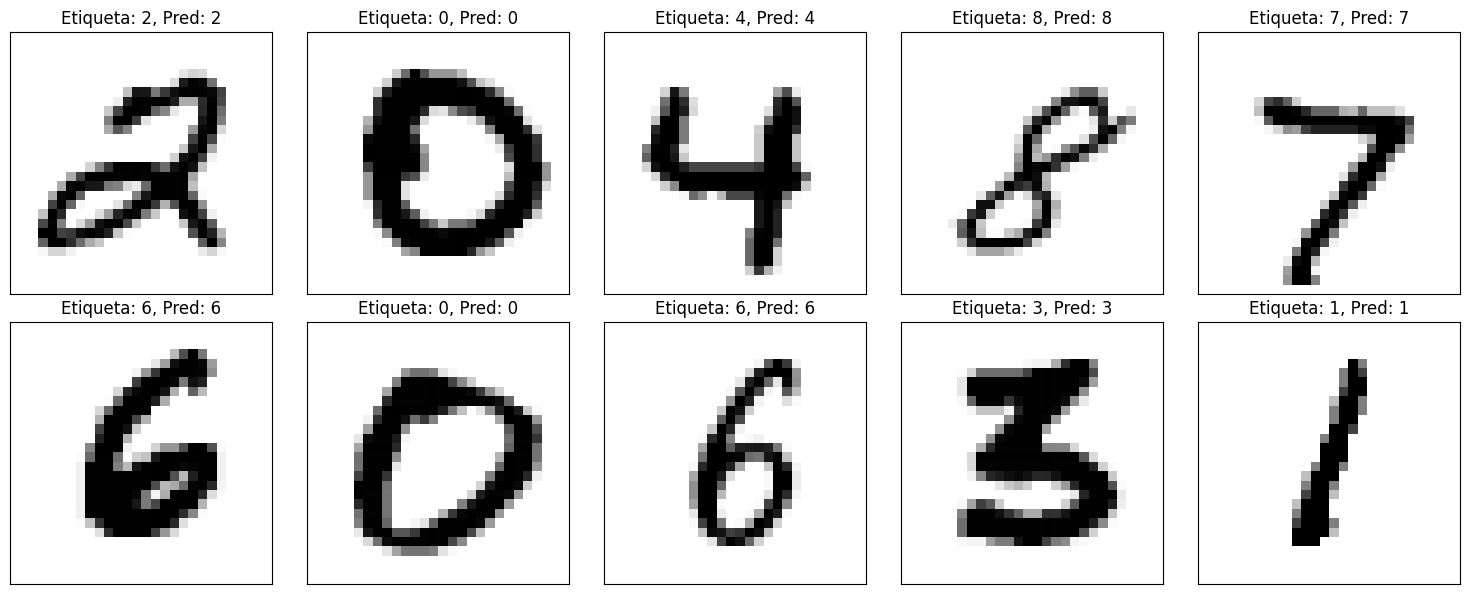

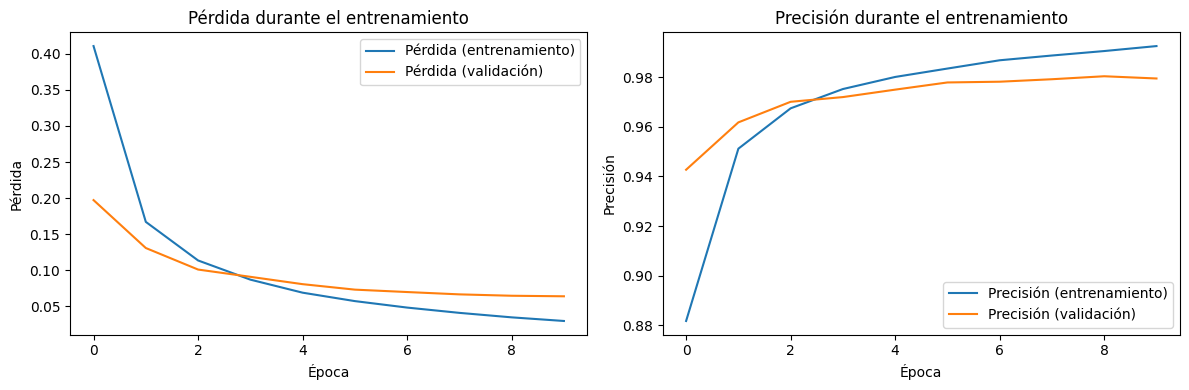

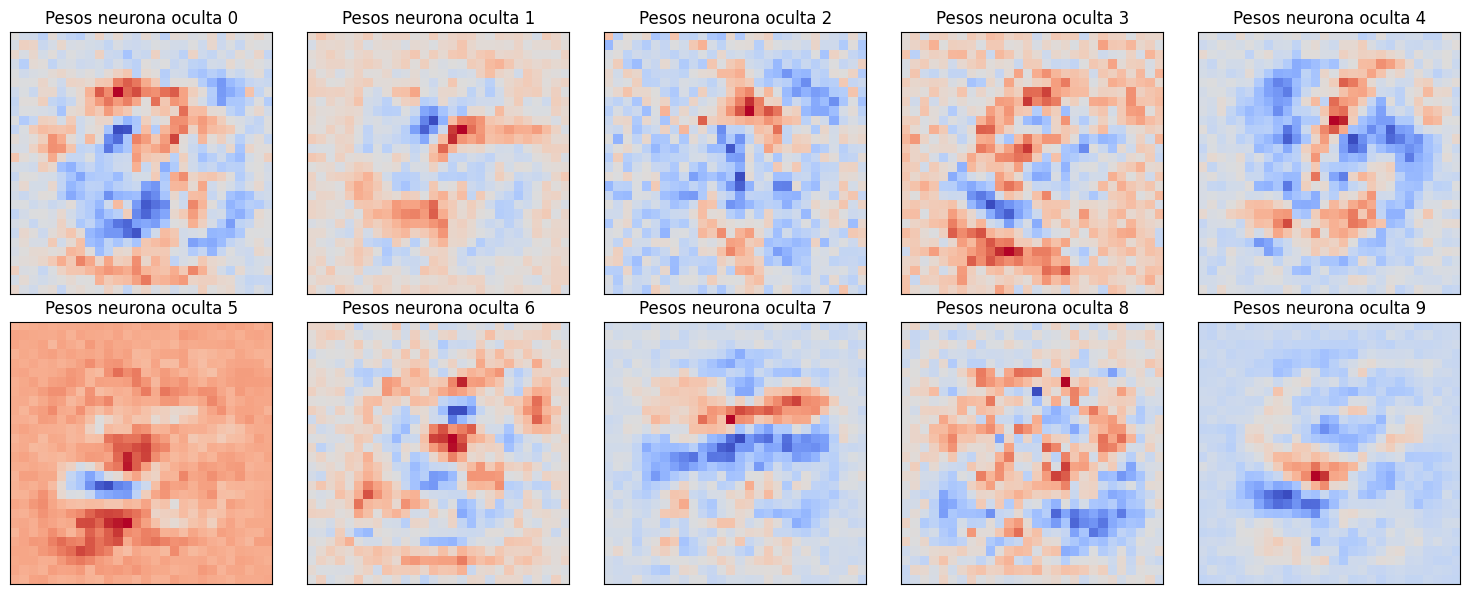

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Paso 1: Preparación de datos
def preprocess_mnist(ds):
    ds = ds.map(lambda item: (tf.cast(item['image'], tf.float32) / 255.0,
                             tf.one_hot(item['label'], depth=10)))
    ds = ds.map(lambda image, label: (tf.reshape(image, (-1,)), label))
    return ds

ds_train, ds_test = tfds.load('mnist', split=['train', 'test'], as_supervised=False)
ds_train = preprocess_mnist(ds_train).cache().shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = preprocess_mnist(ds_test).batch(32).prefetch(tf.data.AUTOTUNE)

# Paso 2: Definir la arquitectura
n_input = 784
n_hidden = 256
n_output = 10

# Inicializar parámetros
W1 = tf.Variable(tf.random.normal([n_input, n_hidden], stddev=0.01))
b1 = tf.Variable(tf.zeros([n_hidden]))
W2 = tf.Variable(tf.random.normal([n_hidden, n_output], stddev=0.01))
b2 = tf.Variable(tf.zeros([n_output]))

# Paso 3: Definir el forward pass
def forward_pass(x):
    h = tf.nn.relu(tf.matmul(x, W1) + b1)  # Capa oculta con ReLU
    logits = tf.matmul(h, W2) + b2         # Capa de salida
    return tf.nn.softmax(logits)           # Probabilidades

# Paso 4: Definir pérdida y métricas
def compute_loss(y_true, y_pred):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=tf.math.log(y_pred + 1e-10)))

def compute_accuracy(y_true, y_pred):
    y_pred_labels = tf.argmax(y_pred, axis=1)
    y_true_labels = tf.argmax(y_true, axis=1)
    return tf.reduce_mean(tf.cast(tf.equal(y_pred_labels, y_true_labels), tf.float32))

# Paso 5: Implementar SGD con momentum
learning_rate = 0.01
momentum = 0.9
velocities = [tf.Variable(tf.zeros_like(w)) for w in [W1, b1, W2, b2]]

def train_step(x, y):
    with tf.GradientTape() as tape:
        predictions = forward_pass(x)
        loss = compute_loss(y, predictions)
    gradients = tape.gradient(loss, [W1, b1, W2, b2])
    for v, g, p in zip(velocities, gradients, [W1, b1, W2, b2]):
        v.assign(momentum * v - learning_rate * g)
        p.assign_add(v)
    return loss, compute_accuracy(y, predictions)

# Paso 6: Entrenamiento
epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    epoch_loss = 0.0
    epoch_acc = 0.0
    num_batches = 0

    for x_batch, y_batch in ds_train:
        loss, acc = train_step(x_batch, y_batch)
        epoch_loss += loss.numpy()
        epoch_acc += acc.numpy()
        num_batches += 1

    train_losses.append(epoch_loss / num_batches)
    train_accuracies.append(epoch_acc / num_batches)

    # Validación
    val_loss = 0.0
    val_acc = 0.0
    num_val_batches = 0
    for x_batch, y_batch in ds_test:
        predictions = forward_pass(x_batch)
        val_loss += compute_loss(y_batch, predictions).numpy()
        val_acc += compute_accuracy(y_batch, predictions).numpy()
        num_val_batches += 1

    val_losses.append(val_loss / num_val_batches)
    val_accuracies.append(val_acc / num_val_batches)

    print(f"Época {epoch+1}/{epochs}, Pérdida: {train_losses[-1]:.4f}, Precisión: {train_accuracies[-1]:.4f}, "
          f"Pérdida Val: {val_losses[-1]:.4f}, Precisión Val: {val_accuracies[-1]:.4f}")

# Paso 7: Evaluación final
test_loss = 0.0
test_acc = 0.0
num_test_batches = 0
for x_batch, y_batch in ds_test:
    predictions = forward_pass(x_batch)
    test_loss += compute_loss(y_batch, predictions).numpy()
    test_acc += compute_accuracy(y_batch, predictions).numpy()
    num_test_batches += 1
print(f"Precisión final en el conjunto de prueba: {test_acc / num_test_batches:.4f}")

# Paso 8: Visualización de predicciones
for x_batch, y_batch in ds_test.take(1):
    predictions = forward_pass(x_batch)
    y_pred = np.argmax(predictions, axis=1)

fig = plt.figure(figsize=(15, 6))
for i, (image, label, pred) in enumerate(zip(x_batch[:10], y_batch[:10], y_pred[:10])):
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(image.numpy().reshape(28, 28), cmap='gray_r')
    ax.set_title(f"Etiqueta: {np.argmax(label.numpy())}, Pred: {pred}", size=12)
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.show()

# Paso 9: Visualización de métricas
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Pérdida (entrenamiento)')
plt.plot(val_losses, label='Pérdida (validación)')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el entrenamiento')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Precisión (entrenamiento)')
plt.plot(val_accuracies, label='Precisión (validación)')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Precisión durante el entrenamiento')
plt.legend()
plt.tight_layout()
plt.show()

# Paso 10: Visualización de pesos
fig = plt.figure(figsize=(15, 6))
for i in range(min(10, n_hidden)):
    ax = fig.add_subplot(2, 5, i+1)
    weight_image = W1.numpy()[:, i].reshape(28, 28)
    ax.imshow(weight_image, cmap='coolwarm')
    ax.set_title(f'Pesos neurona oculta {i}')
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.show()

### **1. ¿Qué es TensorFlow y su uso en Deep Learning?**

TensorFlow, desarrollado por Google, es una biblioteca de código abierto para computación numérica y aprendizaje automático, especialmente optimizada para *deep learning*. Su núcleo está basado en grafos computacionales, donde los datos (tensores) fluyen a través de nodos (operaciones matemáticas). Es ampliamente utilizado para:

- **Construir y entrenar redes neuronales**: Desde modelos simples como perceptrones multicapa (MLP) hasta arquitecturas avanzadas como redes convolucionales (CNN), recurrentes (RNN) o transformers.
- **Despliegue en producción**: TensorFlow permite exportar modelos para dispositivos móviles, web o servidores.
- **Investigación y experimentación**: Su flexibilidad soporta tanto prototipos rápidos como proyectos a gran escala.

TensorFlow es ideal para *deep learning* porque:
- Soporta cálculos en GPU/TPU para acelerar el entrenamiento.
- Ofrece herramientas para preprocesamiento de datos, construcción de modelos y evaluación.
- Tiene una comunidad activa y soporte para múltiples lenguajes (Python es el principal).

---

### **2. Estructura de la API de TensorFlow**

TensorFlow tiene una API modular, con varios niveles de abstracción que se adaptan a diferentes necesidades, desde principiantes hasta expertos. La estructura principal se divide en:

#### **a) API de alto nivel: Keras (tf.keras)**
- **Descripción**: Keras es la API de alto nivel integrada en TensorFlow (desde la versión 2.x). Es la forma más sencilla de construir, entrenar y evaluar modelos de *deep learning*.
- **Características**:
  - Interfaz intuitiva y fácil de usar.
  - Soporta modelos secuenciales y funcionales para arquitecturas complejas.
  - Incluye capas predefinidas (Dense, Conv2D, LSTM, etc.), optimizadores (Adam, SGD) y funciones de pérdida.
- **Uso típico**:
  ```python
  import tensorflow as tf
  from tensorflow.keras import layers, models

  # Crear un modelo secuencial
  model = models.Sequential([
      layers.Dense(64, activation='relu', input_shape=(100,)),
      layers.Dense(10, activation='softmax')
  ])

  # Compilar el modelo
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # Entrenar el modelo
  model.fit(X_train, y_train, epochs=10, batch_size=32)
  ```
- **Cuándo usarla**: Para prototipos rápidos, principiantes o cuando no necesitas personalizar el flujo de entrenamiento.

#### **b) API de bajo nivel: TensorFlow Core**
- **Descripción**: Permite un control granular sobre los grafos computacionales y las operaciones de tensores.
- **Características**:
  - Usa tensores (`tf.Tensor`) y operaciones (`tf.add`, `tf.matmul`) para definir cálculos.
  - Permite crear bucles de entrenamiento personalizados.
  - Compatible con *eager execution* (ejecución dinámica, similar a PyTorch).
- **Uso típico**:
  ```python
  import tensorflow as tf

  # Definir tensores
  x = tf.constant([[1., 2.], [3., 4.]])
  y = tf.constant([[5., 6.], [7., 8.]])

  # Operación matricial
  z = tf.matmul(x, y)

  print(z)
  ```
- **Cuándo usarla**: Para investigación avanzada, optimizaciones personalizadas o cuando necesitas máximo control.

#### **c) Módulos especializados**
TensorFlow ofrece submódulos para tareas específicas:
- **tf.data**: Para construir pipelines de datos eficientes.
  ```python
  dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).shuffle(1000)
  ```
- **tf.keras.preprocessing**: Preprocesamiento de datos (imágenes, texto, secuencias).
- **tf.estimator**: API para modelos predefinidos y flujos de trabajo escalables.
- **tf.lite**: Para convertir modelos a formatos optimizados para dispositivos móviles.
- **tf.hub**: Para usar modelos preentrenados y transfer learning.
- **tf.distribute**: Para entrenamiento distribuido en múltiples GPUs/TPUs.

#### **d) Estructura modular de la API**
La API de TensorFlow está organizada en módulos jerárquicos:
- `tf.keras`: Modelos, capas, optimizadores, métricas.
- `tf.nn`: Funciones para redes neuronales (activaciones, convoluciones).
- `tf.math`: Operaciones matemáticas (suma, producto matricial).
- `tf.train`: Optimizadores y utilidades de entrenamiento.
- `tf.saved_model`: Guardado y carga de modelos.

---

### **3. Flujo típico para Deep Learning con TensorFlow**

El proceso estándar para construir y entrenar un modelo de *deep learning* con TensorFlow sigue estos pasos:

1. **Preparar los datos**:
   - Usa `tf.data` para crear pipelines de entrada.
   - Preprocesa datos con `tf.keras.preprocessing` (e.g., `ImageDataGenerator` para imágenes).
   ```python
   dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
   ```

2. **Definir el modelo**:
   - Usa `tf.keras.Sequential` para modelos lineales o la API funcional para arquitecturas complejas.
   ```python
   model = tf.keras.Sequential([
       layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
       layers.Flatten(),
       layers.Dense(10, activation='softmax')
   ])
   ```

3. **Compilar el modelo**:
   - Especifica el optimizador, la función de pérdida y las métricas.
   ```python
   model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
   ```

4. **Entrenar el modelo**:
   - Usa `model.fit` para entrenar con datos etiquetados.
   ```python
   model.fit(dataset, epochs=5)
   ```

5. **Evaluar y predecir**:
   - Evalúa con `model.evaluate` y predice con `model.predict`.
   ```python
   loss, accuracy = model.evaluate(X_test, y_test)
   predictions = model.predict(X_test)
   ```

6. **Guardar y cargar el modelo**:
   - Usa `model.save` para guardar y `tf.keras.models.load_model` para cargar.
   ```python
   model.save('my_model.h5')
   loaded_model = tf.keras.models.load_model('my_model.h5')
   ```

---

### **4. Ejemplo práctico: Clasificador de imágenes con CNN**

Aquí tienes un ejemplo completo de cómo usar TensorFlow para entrenar una red convolucional en el conjunto de datos MNIST:

```python
import tensorflow as tf
from tensorflow.keras import layers, models

# Cargar y preprocesar datos
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(-1, 28, 28, 1) / 255.0  # Normalizar y reshape
X_test = X_test.reshape(-1, 28, 28, 1) / 255.0

# Crear el modelo
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")
```

---

### **5. Consejos para usar TensorFlow en Deep Learning**

- **Usa Keras para empezar**: Es más simple y cubre la mayoría de los casos de uso.
- **Optimiza el pipeline de datos**: Usa `tf.data` para manejar datasets grandes y evitar cuellos de botella.
- **Aprovecha modelos preentrenados**: Usa `tf.hub` o `tf.keras.applications` (e.g., ResNet, BERT) para *transfer learning*.
- **Monitorea el entrenamiento**: Usa callbacks como `EarlyStopping` o `ModelCheckpoint` para evitar sobreajuste.
  ```python
  callbacks = [tf.keras.callbacks.EarlyStopping(patience=3)]
  model.fit(X_train, y_train, epochs=50, callbacks=callbacks)
  ```
- **Experimenta con hardware**: Configura TensorFlow para usar GPU/TPU si está disponible (`tf.config.list_physical_devices('GPU')`).

---

### **6. Recursos adicionales**
- **Documentación oficial**: [tensorflow.org](https://www.tensorflow.org)
- **Tutoriales de Keras**: [keras.io](https://keras.io)
- **Modelos preentrenados**: [tfhub.dev](https://tfhub.dev)
- **Comunidad**: Busca ejemplos en GitHub o foros como Stack Overflow.



### **1. Dense**
- **Explicación**: Capa densa (fully connected). Cada neurona de esta capa está conectada a todas las neuronas de la capa anterior, aplicando una transformación lineal seguida de una función de activación (si se especifica).
- **Funcionalidad**: Se usa para combinar características extraídas en capas anteriores o para la salida final (e.g., clasificación).
- **Parámetros clave**:
  - `units`: Número de neuronas.
  - `activation`: Función de activación (e.g., `'relu'`, `'softmax'`).
- **Uso típico**: Capas de salida en clasificación o capas intermedias en redes feedforward.
- **Ejemplo**:
  ```python
  from tensorflow.keras import layers
  dense_layer = layers.Dense(64, activation='relu')
  ```

---

### **2. Conv1D**
- **Explicación**: Capa de convolución 1D. Aplica un filtro unidimensional a secuencias de datos (e.g., series temporales, texto) para extraer características locales.
- **Funcionalidad**: Desliza un kernel (filtro) sobre los datos para detectar patrones, reduciendo la necesidad de conexiones densas.
- **Parámetros clave**:
  - `filters`: Número de filtros.
  - `kernel_size`: Tamaño del filtro.
  - `activation`: Función de activación.
- **Uso típico**: Procesamiento de señales 1D como audio o texto procesado (e.g., embeddings).
- **Ejemplo**:
  ```python
  conv1d_layer = layers.Conv1D(filters=32, kernel_size=3, activation='relu')
  ```

---

### **3. Conv2D**
- **Explicación**: Capa de convolución 2D. Aplica filtros bidimensionales a datos como imágenes para extraer características espaciales (e.g., bordes, texturas).
- **Funcionalidad**: Esencial en redes convolucionales (CNN) para visión por computadora.
- **Parámetros clave**:
  - `filters`: Número de filtros.
  - `kernel_size`: Tamaño del filtro (e.g., `(3, 3)`).
  - `padding`: `'same'` o `'valid'` para manejar bordes.
- **Uso típico**: Clasificación de imágenes, detección de objetos.
- **Ejemplo**:
  ```python
  conv2d_layer = layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))
  ```

---

### **4. MaxPooling1D**
- **Explicación**: Capa de agrupación máxima 1D. Reduce las dimensiones espaciales tomando el valor máximo en ventanas deslizantes a lo largo de una dimensión.
- **Funcionalidad**: Disminuye la resolución espacial, reduciendo parámetros y evitando sobreajuste.
- **Parámetros clave**:
  - `pool_size`: Tamaño de la ventana de agrupación.
- **Uso típico**: Reducción de dimensionalidad en series temporales o texto.
- **Ejemplo**:
  ```python
  maxpool1d_layer = layers.MaxPooling1D(pool_size=2)
  ```

---

### **5. MaxPooling2D**
- **Explicación**: Capa de agrupación máxima 2D. Similar a MaxPooling1D, pero opera en dos dimensiones (alto y ancho).
- **Funcionalidad**: Común en CNN para reducir el tamaño de mapas de características.
- **Parámetros clave**:
  - `pool_size`: Tamaño de la ventana (e.g., `(2, 2)`).
- **Uso típico**: Procesamiento de imágenes tras capas Conv2D.
- **Ejemplo**:
  ```python
  maxpool2d_layer = layers.MaxPooling2D((2, 2))
  ```

---

### **6. Dropout**
- **Explicación**: Capa que aplica la eliminación aleatoria de una fracción de las entradas durante el entrenamiento.
- **Funcionalidad**: Previene el sobreajuste al forzar a la red a no depender demasiado de neuronas específicas.
- **Parámetros clave**:
  - `rate`: Fracción de entradas a eliminar (e.g., 0.2 para 20%).
- **Uso típico**: Regularización en cualquier red profunda.
- **Ejemplo**:
  ```python
  dropout_layer = layers.Dropout(0.2)
  ```

---

### **7. Flatten**
- **Explicación**: Capa que aplana la entrada (e.g., un tensor multidimensional) en un vector 1D.
- **Funcionalidad**: Convierte mapas de características (como los de Conv2D) en un formato adecuado para capas densas.
- **Parámetros clave**: No requiere parámetros adicionales.
- **Uso típico**: Puente entre capas convolucionales y densas.
- **Ejemplo**:
  ```python
  flatten_layer = layers.Flatten()
  ```

---

### **8. Embedding**
- **Explicación**: Convierte enteros positivos (índices de etiquetas, como palabras en un vocabulario) en vectores densos de tamaño fijo.
- **Funcionalidad**: Usada en procesamiento de lenguaje natural (NLP) para representar palabras o tokens en un espacio vectorial.
- **Parámetros clave**:
  - `input_dim`: Tamaño del vocabulario.
  - `output_dim`: Dimensionalidad de los vectores de embedding.
- **Uso típico**: Modelos de texto (e.g., RNN, transformers).
- **Ejemplo**:
  ```python
  embedding_layer = layers.Embedding(input_dim=1000, output_dim=64)
  ```

---

### **9. SimpleRNN**
- **Explicación**: Red neuronal recurrente (RNN) básica donde la salida se retroalimenta a la entrada en el siguiente paso de tiempo.
- **Funcionalidad**: Procesa secuencias (e.g., series temporales, texto) manteniendo un estado interno.
- **Parámetros clave**:
  - `units`: Número de unidades recurrentes.
  - `activation`: Función de activación.
- **Uso típico**: Tareas simples de secuencias (aunque LSTM es más común hoy en día).
- **Ejemplo**:
  ```python
  rnn_layer = layers.SimpleRNN(32, activation='tanh')
  ```

---

### **10. LSTM**
- **Explicación**: Capa de memoria a largo plazo (LSTM), una variante avanzada de RNN con puertas (forget, input, output) para manejar dependencias a largo plazo.
- **Funcionalidad**: Ideal para secuencias largas donde SimpleRNN falla por el problema de desvanecimiento del gradiente.
- **Parámetros clave**:
  - `units`: Número de unidades.
  - `return_sequences`: Si devuelve toda la secuencia o solo el último estado.
- **Uso típico**: Predicción de series temporales, traducción automática.
- **Ejemplo**:
  ```python
  lstm_layer = layers.LSTM(64, return_sequences=True)
  ```

---

### **11. TimeDistributed**
- **Explicación**: Contenedor que aplica una capa (e.g., Dense, Conv2D) a cada intervalo de tiempo de una secuencia.
- **Funcionalidad**: Útil en modelos que procesan secuencias donde cada paso de tiempo requiere la misma transformación.
- **Parámetros clave**:
  - `layer`: Capa a distribuir (e.g., `layers.Dense(10)`).
- **Uso típico**: Combinación de CNN y RNN (e.g., video o texto con embeddings).
- **Ejemplo**:
  ```python
  time_distributed = layers.TimeDistributed(layers.Dense(10))
  ```

---

### **12. Input**
- **Explicación**: Capa de entrada, la primera en un modelo usando la API funcional de Keras.
- **Funcionalidad**: Define la forma y el tipo de datos de entrada al modelo.
- **Parámetros clave**:
  - `shape`: Forma de la entrada (excluyendo el batch size).
  - `dtype`: Tipo de datos (e.g., `float32`).
- **Uso típico**: Base para construir modelos funcionales en lugar de secuenciales.
- **Ejemplo**:
  ```python
  input_layer = layers.Input(shape=(28, 28, 1))
  ```

---

### **Ejemplo combinado: Modelo con varias capas**
Aquí tienes un ejemplo que combina varias de estas capas para un modelo de clasificación de imágenes con secuencias (e.g., video):

```python
from tensorflow.keras import layers, models

# Definir entrada
inputs = layers.Input(shape=(10, 28, 28, 1))  # 10 frames de 28x28

# Capas convolucionales y pooling
x = layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu'))(inputs)
x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)

# Aplanar y RNN
x = layers.TimeDistributed(layers.Flatten())(x)
x = layers.LSTM(64)(x)

# Capa densa y salida
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

# Crear modelo
model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
```

---

### **Notas adicionales**
- **Combinación de capas**: Las capas como Conv2D y MaxPooling2D suelen apilarse en CNN, mientras que LSTM y TimeDistributed se usan en redes recurrentes para secuencias.
- **Personalización**: Puedes ajustar hiperparámetros (e.g., `kernel_size`, `units`) según el problema.
- **Regularización**: Usa Dropout entre capas para mejorar la generalización.



ejemplo del material origial:

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [3]:
tf.__version__

'2.19.0'

In [4]:
import pandas as pd
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
df = pd.read_csv('data_boston.csv', header='infer', encoding='latin1')
X = df.drop(columns=['PRICE'])
y = df['PRICE']

In [6]:
df.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [7]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
n_vars = X_train.shape[1]

In [9]:
n_vars

13

In [10]:
my_model1 = Sequential()
my_model1.add(Dense(input_dim=n_vars, units=1, activation="linear"))

In [11]:
my_model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
n_epochs = 2000
batch_size = 10
learn_rate = 0.002

In [15]:
my_optimizer=Adam(learning_rate=learn_rate)
my_model1.compile(loss="mae", optimizer=my_optimizer, metrics=["mse"])

In [16]:
my_summary = my_model1.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                           validation_split=0.2, verbose=1)

Epoch 1/2000
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 24.1082 - mse: 669.0674 - val_loss: 23.3602 - val_mse: 618.3262
Epoch 2/2000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.5099 - mse: 702.9505 - val_loss: 23.0211 - val_mse: 603.2437
Epoch 3/2000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.1412 - mse: 624.5593 - val_loss: 22.6817 - val_mse: 588.3912
Epoch 4/2000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.8379 - mse: 613.8417 - val_loss: 22.3443 - val_mse: 573.8503
Epoch 5/2000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.6239 - mse: 609.8622 - val_loss: 22.0043 - val_mse: 559.4586
Epoch 6/2000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.9693 - mse: 581.5631 - val_loss: 21.6663 - val_mse: 545.3755
Epoch 7/2000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.5946 - mse: 557.0889 - val_loss: 21.3265 - val_mse: 531.4698
Epoch 8/2000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.4896 - mse: 498.6681 - val_loss: 20.9882 - val_mse: 517.8641
Epoch 9

In [17]:
my_summary.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

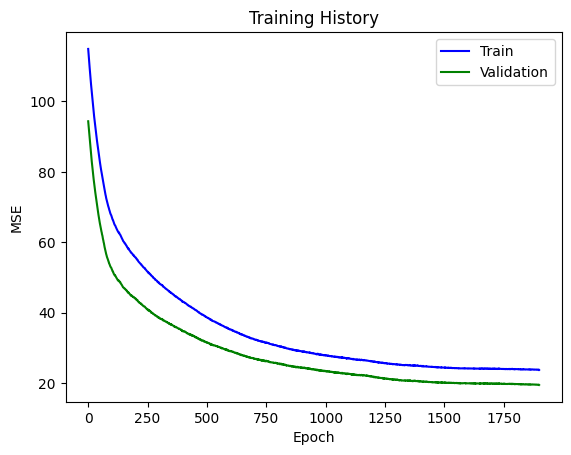

In [18]:
n_skip = 100
plt.plot(my_summary.history['mse'][n_skip:], c="b")
plt.plot(my_summary.history['val_mse'][n_skip:], c="g")
plt.title('Training History')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [19]:
y_pred = my_model1.predict(X_test)[:, 0]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [20]:
RMSE = np.sqrt(np.mean((y_test-y_pred)**2))
np.round(RMSE, 3)

np.float64(5.63)

In [21]:
RMSE

np.float64(5.630263809663969)

In [22]:
MSE = my_model1.evaluate(X_test, y_test, verbose=0)[1]
RMSE = np.sqrt(MSE)
print("Test RMSE : {}".format(np.round(RMSE, 3)))

Test RMSE : 5.63


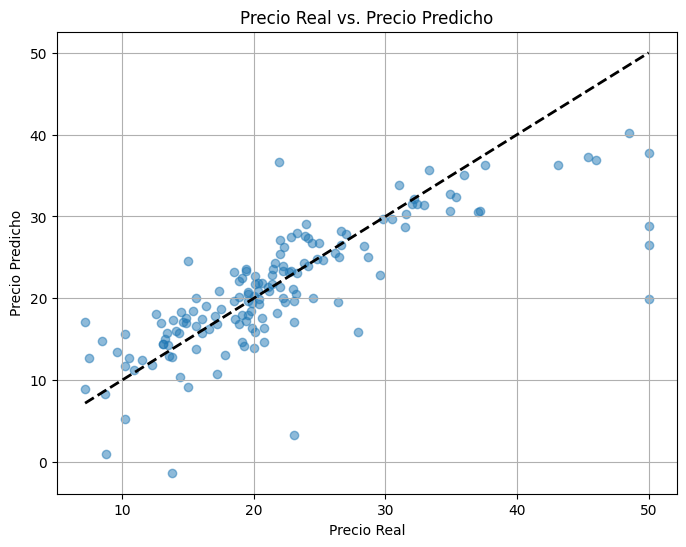

In [23]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Precio Real')
plt.ylabel('Precio Predicho')
plt.title('Precio Real vs. Precio Predicho')
plt.grid(True)
plt.show()

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

In [25]:
my_input = Input(shape=(n_vars,))
my_output = Dense(units=1, activation='linear')(my_input)

In [26]:
my_model2 = Model(inputs=my_input, outputs=my_output)

In [27]:
my_model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
my_optimizer=Adam(learning_rate=learn_rate)
my_model2.compile(loss="mae", optimizer=my_optimizer, metrics=["mse"])

In [29]:
my_summary = my_model2.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                           validation_split=0.2, verbose=0)

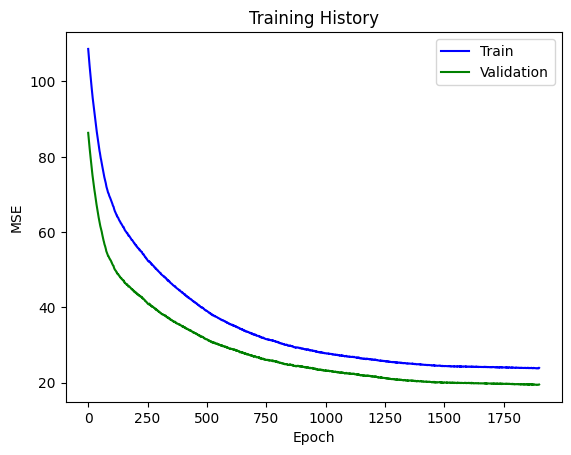

In [30]:
n_skip = 100
plt.plot(my_summary.history['mse'][n_skip:], c="b")
plt.plot(my_summary.history['val_mse'][n_skip:], c="g")
plt.title('Training History')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [31]:
MSE = my_model2.evaluate(X_test, y_test, verbose=0)[1]
RMSE = np.sqrt(MSE)
print("Test RMSE : {}".format(np.round(RMSE, 3)))

Test RMSE : 5.658


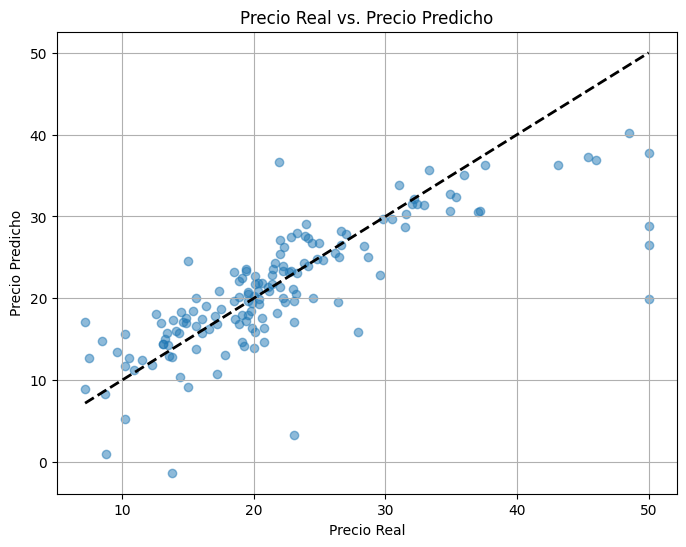

In [32]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Precio Real')
plt.ylabel('Precio Predicho')
plt.title('Precio Real vs. Precio Predicho')
plt.grid(True)
plt.show()

In [33]:
df = pd.read_csv('data_boston.csv', header='infer', encoding='latin1')
X = df.drop(columns=['PRICE', 'B'])
y = df['PRICE']

In [34]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33


In [35]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
n_vars = X_train.shape[1]

In [37]:
my_model3 = Sequential()
my_model3.add(Dense(input_dim=n_vars, units=1, activation="linear"))

In [38]:
my_model3.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

In [39]:
n_epochs = 2000
batch_size = 10
learn_rate = 0.002

In [40]:
my_optimizer=Adam(learning_rate=learn_rate)
my_model3.compile(loss="mae", optimizer=my_optimizer, metrics=["mse"])

In [41]:
my_summary = my_model3.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                           validation_split=0.2, verbose=0)

In [42]:
my_summary.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

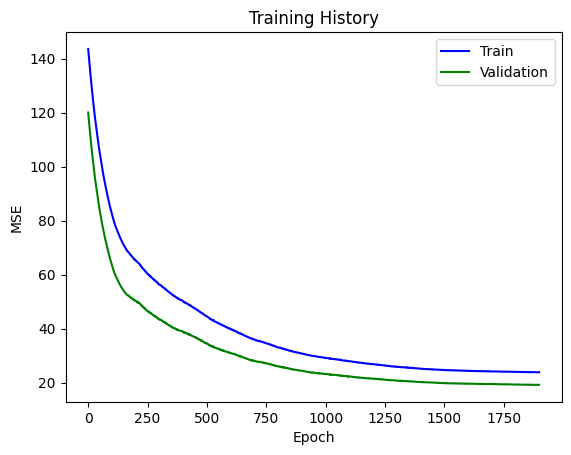

In [43]:
n_skip = 100
plt.plot(my_summary.history['mse'][n_skip:], c="b")
plt.plot(my_summary.history['val_mse'][n_skip:], c="g")
plt.title('Training History')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [45]:
y_pred = my_model3.predict(X_test)[:, 0]
RMSE = np.sqrt(np.mean((y_test-y_pred)**2))
np.round(RMSE, 3)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


np.float64(5.824)

In [46]:
MSE = my_model3.evaluate(X_test, y_test, verbose=0)[1]
RMSE = np.sqrt(MSE)
print("Test RMSE : {}".format(np.round(RMSE, 3)))

Test RMSE : 5.824


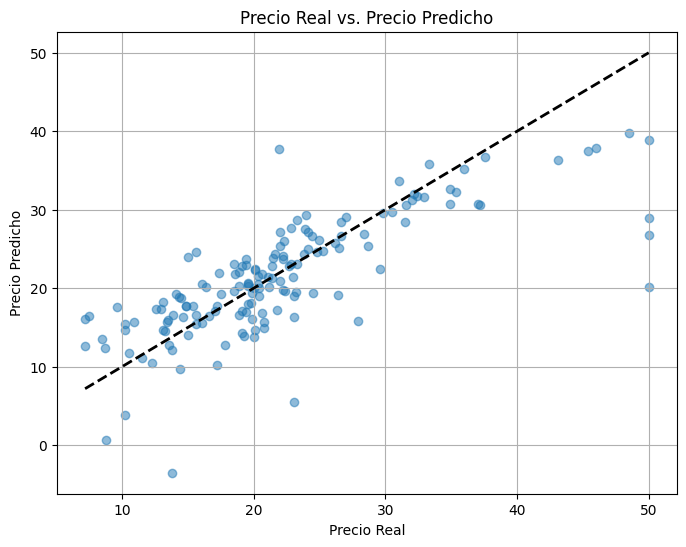

In [47]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Precio Real')
plt.ylabel('Precio Predicho')
plt.title('Precio Real vs. Precio Predicho')
plt.grid(True)
plt.show()

ejercicio con iris

In [48]:
import os
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_iris
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline

In [49]:
data_raw = load_iris()
X = data_raw['data']
y0 = data_raw['target'].reshape(-1, 1)

In [50]:
import tensorflow as tf

In [52]:
y = tf.keras.utils.to_categorical(y0, num_classes=3)

In [53]:
header = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species_0', 'Species_1', 'Species_2']
df = pd.DataFrame(np.concatenate([X, y], axis=1), columns=header)
df.head(5)

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species_0,Species_1,Species_2
0,5.1,3.5,1.4,0.2,1.0,0.0,0.0
1,4.9,3.0,1.4,0.2,1.0,0.0,0.0
2,4.7,3.2,1.3,0.2,1.0,0.0,0.0
3,4.6,3.1,1.5,0.2,1.0,0.0,0.0
4,5.0,3.6,1.4,0.2,1.0,0.0,0.0


Los tres métodos, **MinMaxScaler**, **StandardScaler** y **RobustScaler**, son técnicas de escalado de datos utilizadas en preprocesamiento para machine learning, pero difieren en cómo transforman los datos y en qué casos son más adecuados. A continuación, te explico las diferencias de forma clara y concisa:

### 1. **MinMaxScaler**
- **Qué hace**: Escala los datos a un rango fijo, típicamente [0, 1] o [-1, 1], usando los valores mínimo y máximo de la característica.
- **Fórmula**:
  \[
  X_{\text{scaled}} = \frac{X - X_{\min}}{X_{\max} - X_{\min}} \cdot (\text{rango_max} - \text{rango_min}) + \text{rango_min}
  \]
- **Cuándo usarlo**:
  - Cuando los datos no tienen valores atípicos (outliers) significativos.
  - Modelos que requieren datos en un rango específico, como redes neuronales o algoritmos sensibles a la escala (e.g., SVM, KNN).
- **Ventajas**:
  - Mantiene la distribución original de los datos.
  - Útil cuando se necesita un rango fijo.
- **Desventajas**:
  - Sensible a outliers, ya que los valores extremos afectan el rango.

### 2. **StandardScaler**
- **Qué hace**: Estandariza los datos para que tengan media 0 y desviación estándar 1 (distribución normal estándar).
- **Fórmula**:
  \[
  X_{\text{scaled}} = \frac{X - \mu}{\sigma}
  \]
  Donde \(\mu\) es la media y \(\sigma\) es la desviación estándar.
- **Cuándo usarlo**:
  - Cuando los datos siguen una distribución aproximadamente normal.
  - Modelos que asumen datos estandarizados, como regresión lineal, regresión logística o PCA.
- **Ventajas**:
  - Menos sensible a outliers que MinMaxScaler.
  - Adecuado para la mayoría de los algoritmos de machine learning.
- **Desventajas**:
  - Puede no ser ideal si los datos tienen muchos outliers o no son gaussianos.

### 3. **RobustScaler**
- **Qué hace**: Escala los datos usando estadísticas robustas, como la mediana y los cuartiles (rango intercuartílico, IQR), en lugar de la media y desviación estándar.
- **Fórmula**:
  \[
  X_{\text{scaled}} = \frac{X - \text{mediana}}{\text{IQR}}
  \]
  Donde IQR = Q3 - Q1 (rango intercuartílico).
- **Cuándo usarlo**:
  - Cuando los datos tienen muchos outliers o no siguen una distribución normal.
  - Datasets con valores extremos que podrían distorsionar otros escaladores.
- **Ventajas**:
  - Muy robusto frente a outliers, ya que usa la mediana y el IQR.
  - Ideal para datos con distribuciones no gaussianas.
- **Desventajas**:
  - No asegura un rango fijo como MinMaxScaler.
  - Puede no ser óptimo si los datos no tienen outliers significativos.

### Resumen comparativo
| **Escalador**       | **Base**                     | **Rango**            | **Sensibilidad a outliers** | **Mejor caso de uso**                              |
|---------------------|-----------------------------|----------------------|-----------------------------|--------------------------------------------------|
| **MinMaxScaler**    | Mínimo y máximo             | [0, 1] o personalizado | Alta                        | Datos sin outliers, modelos sensibles al rango    |
| **StandardScaler**  | Media y desviación estándar | Media 0, desv. 1     | Moderada                    | Datos gaussianos, modelos lineales               |
| **RobustScaler**    | Mediana y IQR               | Variable             | Baja                        | Datos con outliers, distribuciones no normales   |

### Ejemplo práctico
Si tienes un dataset con valores de ingresos que incluyen algunos outliers extremos (e.g., multimillonarios), **RobustScaler** es mejor porque ignora los valores extremos. Si los datos son limpios y necesitas un rango [0, 1] para una red neuronal, **MinMaxScaler** es ideal. Si trabajas con un modelo que asume normalidad, como PCA, **StandardScaler** es la mejor opción.



In [54]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
n_vars = X_train.shape[1]

In [56]:
my_model = Sequential()
my_model.add(Dense(input_dim=n_vars, units=3, activation="softmax"))

In [57]:
my_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 3)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15 (60.00 B)

 Trainable params: 15 (60.00 B)

 Non-trainable params: 0 (0.00 B)

In [58]:
n_epochs = 500
batch_size = 10
learn_rate = 0.005

In [59]:
my_optimizer=Adam(learning_rate=learn_rate)
my_model.compile(loss="categorical_crossentropy", optimizer=my_optimizer, metrics=["accuracy"])

In [60]:
my_summary = my_model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                           validation_split=0.2, verbose=1)

Epoch 1/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.7198 - loss: 1.2688 - val_accuracy: 0.5714 - val_loss: 1.4726
Epoch 2/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7312 - loss: 1.2290 - val_accuracy: 0.5714 - val_loss: 1.4002
Epoch 3/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7604 - loss: 1.1288 - val_accuracy: 0.5714 - val_loss: 1.3341
Epoch 4/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6777 - loss: 1.1922 - val_accuracy: 0.5714 - val_loss: 1.2682
Epoch 5/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7078 - loss: 1.1213 - val_accuracy: 0.5714 - val_loss: 1.2206
Epoch 6/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6884 - loss: 1.1002 - val_accuracy: 0.5714 - val_loss: 1.1777
Epoch 7/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7265 - loss: 1.0429 - val_accuracy: 0.5714 - val_loss: 1.1385
Epoch 8/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7215 - loss: 1.0177 - val_accuracy: 0.5714 - val_loss: 1.105

In [61]:
my_summary.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

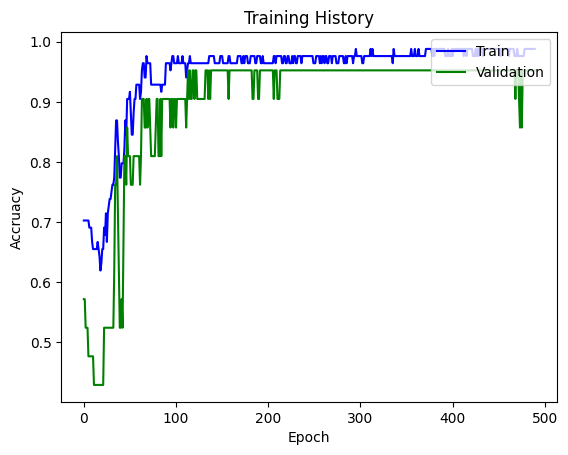

In [62]:
n_skip = 10
plt.plot(my_summary.history['accuracy'][n_skip:], c="b")
plt.plot(my_summary.history['val_accuracy'][n_skip:], c="g")
plt.title('Training History')
plt.ylabel('Accruacy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [63]:
ACC = my_model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy : {}".format(np.round(ACC, 3)))

Test Accuracy : 0.933


# Task
Create a new exercise at the end of the notebook to compare with the previous one. Load the iris dataset again and work with machine learning, using decision trees and random forests.

## Cargar y preparar los datos de iris

### Subtask:
Cargar el dataset de Iris y separar las características y la variable objetivo.


**Reasoning**:
Load the iris dataset and separate the features and target variable as instructed.



In [1]:
from sklearn.datasets import load_iris
data_raw = load_iris()
X = data_raw['data']
y = data_raw['target']

## Dividir los datos

### Subtask:
Dividir los datos en conjuntos de entrenamiento y prueba.


**Reasoning**:
Split the data into training and testing sets as requested by the instructions.



In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Entrenar un modelo de árbol de decisión

### Subtask:
Entrenar un clasificador de Árbol de Decisión en los datos de entrenamiento.


**Reasoning**:
Train a Decision Tree Classifier model on the training data.



In [3]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(random_state=123)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=123)

## Evaluar el modelo de árbol de decisión

### Subtask:
Evaluar el rendimiento del modelo de Árbol de Decisión en los datos de prueba.


**Reasoning**:
Import the required metric, make predictions using the trained Decision Tree model, calculate the accuracy, and print the result.



In [4]:
from sklearn.metrics import accuracy_score

y_pred_dt = dt_classifier.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy del Árbol de Decisión: {accuracy_dt:.3f}")

Accuracy del Árbol de Decisión: 0.956


## Entrenar un modelo de random forest

### Subtask:
Entrenar un clasificador de Random Forest en los datos de entrenamiento.


**Reasoning**:
Import the RandomForestClassifier and train the model on the training data.



In [5]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=123)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

## Evaluar el modelo de random forest

### Subtask:
Evaluar el rendimiento del modelo de Random Forest en los datos de prueba.


**Reasoning**:
Evaluate the Random Forest model by making predictions on the test set and calculating the accuracy.



In [6]:
from sklearn.metrics import accuracy_score

y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy del Random Forest: {accuracy_rf:.3f}")

Accuracy del Random Forest: 0.933


## Comparar resultados

### Subtask:
Comparar las métricas de evaluación de los modelos de Árbol de Decisión, Random Forest y la red neuronal anterior.


**Reasoning**:
Print the accuracies of the Decision Tree, Random Forest, and Neural Network models and identify the best performing model.



In [9]:
ACC = 0.933

In [10]:
print(f"Accuracy del Árbol de Decisión: {accuracy_dt:.3f}")
print(f"Accuracy del Random Forest: {accuracy_rf:.3f}")
# The accuracy for the neural network model was already printed in cell k3VzLSSHaPdD
# ACC = my_model.evaluate(X_test, y_test, verbose=0)[1]
# print("Test Accuracy : {}".format(np.round(ACC, 3)))
# Assuming the variable ACC holds the neural network accuracy from the previous cell
print(f"Accuracy de la Red Neuronal: {ACC:.3f}")

# Identify the best performing model
accuracies = {
    "Árbol de Decisión": accuracy_dt,
    "Random Forest": accuracy_rf,
    "Red Neuronal": ACC
}

best_model = max(accuracies, key=accuracies.get)
highest_accuracy = accuracies[best_model]

print(f"\nEl modelo con el mejor rendimiento en el conjunto de prueba es: {best_model} con una precisión de {highest_accuracy:.3f}")

# Consider if there is any significant difference
# This is a subjective step, but we can comment on the observed differences.
print("\nObservaciones sobre las diferencias de precisión:")
if abs(accuracy_dt - accuracy_rf) < 0.02: # Example threshold for 'significant'
    print("- La precisión entre el Árbol de Decisión y Random Forest es similar.")
else:
    print("- Hay una diferencia notable en la precisión entre el Árbol de Decisión y Random Forest.")

if abs(accuracy_dt - ACC) < 0.02 and abs(accuracy_rf - ACC) < 0.02:
     print("- La precisión de la Red Neuronal es similar a la de los modelos de árbol.")
elif ACC > accuracy_dt and ACC > accuracy_rf:
     print("- La Red Neuronal tiene una precisión notablemente mayor que los modelos de árbol.")
elif ACC < accuracy_dt and ACC < accuracy_rf:
     print("- La Red Neuronal tiene una precisión notablemente menor que los modelos de árbol.")
else:
    print("- La precisión de la Red Neuronal difiere de al menos uno de los modelos de árbol.")


Accuracy del Árbol de Decisión: 0.956
Accuracy del Random Forest: 0.933
Accuracy de la Red Neuronal: 0.933

El modelo con el mejor rendimiento en el conjunto de prueba es: Árbol de Decisión con una precisión de 0.956

Observaciones sobre las diferencias de precisión:
- Hay una diferencia notable en la precisión entre el Árbol de Decisión y Random Forest.
- La Red Neuronal tiene una precisión notablemente menor que los modelos de árbol.


**Reasoning**:
The previous code failed because the variable `ACC` was not defined in the current cell's scope. I need to re-evaluate the neural network model to get the `ACC` value and then perform the comparison.



# Task
Using `GridSearchCV`, find the best hyperparameters for the Decision Tree and Random Forest models on the Iris dataset, compare their performance, and identify the best performing model.

## Importar librerías necesarias

### Subtask:
Importar `GridSearchCV` y las métricas de evaluación.


**Reasoning**:
Import the necessary libraries for GridSearchCV and accuracy score as requested by the instructions.



In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

## Definir la cuadrícula de hiperparámetros para el árbol de decisión

### Subtask:
Especificar los rangos de hiperparámetros a probar para el `DecisionTreeClassifier`.


**Reasoning**:
Create a dictionary to define the hyperparameter grid for the Decision Tree Classifier as requested.



In [12]:
param_grid_dt = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

## Aplicar gridsearchcv para el árbol de decisión

### Subtask:
Configurar y ejecutar `GridSearchCV` en el modelo de Árbol de Decisión con los datos de entrenamiento.


**Reasoning**:
Instantiate DecisionTreeClassifier and GridSearchCV and fit to the training data.



In [13]:
dt_classifier = DecisionTreeClassifier(random_state=123)
grid_search_dt = GridSearchCV(dt_classifier, param_grid_dt, cv=5)
grid_search_dt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=123),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

**Reasoning**:
Print the best parameters found by GridSearchCV for the Decision Tree model.



In [14]:
print("Mejores parámetros para Árbol de Decisión:", grid_search_dt.best_params_)

Mejores parámetros para Árbol de Decisión: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


**Reasoning**:
Print the best cross-validation score achieved by the Decision Tree model with the best parameters.



In [15]:
print("Mejor puntuación de validación cruzada (Accuracy) para Árbol de Decisión:", grid_search_dt.best_score_)

Mejor puntuación de validación cruzada (Accuracy) para Árbol de Decisión: 0.9333333333333333


## Imprimir los mejores hiperparámetros y puntuación para el árbol de decisión

### Subtask:
Imprimir los mejores hiperparámetros y puntuación para el Árbol de decisión.


**Reasoning**:
Print the best hyperparameters and the best cross-validation score for the Decision Tree model using the results from the GridSearchCV.



In [16]:
print("Mejores parámetros para Árbol de Decisión:", grid_search_dt.best_params_)
print("Mejor puntuación de validación cruzada (Accuracy) para Árbol de Decisión:", grid_search_dt.best_score_)

Mejores parámetros para Árbol de Decisión: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor puntuación de validación cruzada (Accuracy) para Árbol de Decisión: 0.9333333333333333


## Definir la cuadrícula de hiperparámetros para el random forest

### Subtask:
Especificar los rangos de hiperparámetros a probar para el `RandomForestClassifier`.


**Reasoning**:
Define the hyperparameter grid for the RandomForestClassifier as instructed.



In [17]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

## Aplicar gridsearchcv para el random forest

### Subtask:
Configurar y ejecutar `GridSearchCV` en el modelo de Random Forest con los datos de entrenamiento.


**Reasoning**:
Configure and execute GridSearchCV on the Random Forest model with the training data as instructed.



In [18]:
rf_classifier = RandomForestClassifier(random_state=123)
grid_search_rf = GridSearchCV(rf_classifier, param_grid_rf, cv=5)
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

**Reasoning**:
Print the best hyperparameters and best cross-validation score found by GridSearchCV for the Random Forest model.



In [19]:
print("Mejores parámetros para Random Forest:", grid_search_rf.best_params_)
print("Mejor puntuación de validación cruzada (Accuracy) para Random Forest:", grid_search_rf.best_score_)

Mejores parámetros para Random Forest: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Mejor puntuación de validación cruzada (Accuracy) para Random Forest: 0.9333333333333333


## Imprimir los mejores hiperparámetros y puntuación para el random forest

### Subtask:
Imprimir los mejores hiperparámetros y puntuación para el random forest


**Reasoning**:
Print the best hyperparameters and the best cross-validation score for the Random Forest model as requested.



In [20]:
print("Mejores parámetros para Random Forest:", grid_search_rf.best_params_)
print("Mejor puntuación de validación cruzada (Accuracy) para Random Forest:", grid_search_rf.best_score_)

Mejores parámetros para Random Forest: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Mejor puntuación de validación cruzada (Accuracy) para Random Forest: 0.9333333333333333


## Comparar los mejores modelos

### Subtask:
Comparar el rendimiento de los modelos optimizados de Árbol de Decisión y Random Forest.


**Reasoning**:
Obtain the best estimators from GridSearchCV for both models, evaluate their performance on the test set, and print the accuracies to compare them.



In [21]:
best_dt_model = grid_search_dt.best_estimator_
best_rf_model = grid_search_rf.best_estimator_

accuracy_dt_optimized = best_dt_model.score(X_test, y_test)
accuracy_rf_optimized = best_rf_model.score(X_test, y_test)

print(f"Accuracy del Árbol de Decisión optimizado: {accuracy_dt_optimized:.3f}")
print(f"Accuracy del Random Forest optimizado: {accuracy_rf_optimized:.3f}")

Accuracy del Árbol de Decisión optimizado: 0.956
Accuracy del Random Forest optimizado: 0.933


## Summary:

### Data Analysis Key Findings

*   The best hyperparameters for the Decision Tree model were found to be `{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}` with a best cross-validation accuracy of approximately 0.9333.
*   The best hyperparameters for the Random Forest model were `{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}` with a best cross-validation accuracy of approximately 0.9333.
*   On the test set, the optimized Decision Tree model achieved an accuracy of 0.956.
*   On the test set, the optimized Random Forest model achieved an accuracy of 0.933.

### Insights or Next Steps

*   Although both models had similar cross-validation scores, the optimized Decision Tree performed slightly better on the unseen test data.
*   Further investigation could involve exploring a wider range of hyperparameters or different cross-validation strategies to see if the Random Forest's test performance can be improved.


Las **redes neuronales convolucionales** (Convolutional Neural Networks, CNN) son un tipo de red neuronal diseñada específicamente para procesar datos estructurados en forma de rejilla, como imágenes o series temporales. Son ampliamente utilizadas en tareas de visión por computadora, como clasificación de imágenes, detección de objetos y reconocimiento facial, debido a su capacidad para capturar patrones espaciales y jerárquicos en los datos. A continuación, te proporciono una explicación detallada de cómo funcionan, sus componentes, su arquitectura y su aplicación, con un enfoque claro y estructurado.

---

### **1. ¿Qué es una red neuronal convolucional?**
Una CNN es una red neuronal que utiliza **convoluciones**, una operación matemática que aplica filtros a los datos de entrada para extraer características relevantes, como bordes, texturas o formas en imágenes. A diferencia de las redes neuronales completamente conectadas, las CNN aprovechan la estructura espacial de los datos (por ejemplo, píxeles cercanos en una imagen están relacionados) para reducir el número de parámetros y mejorar la eficiencia computacional.

Las CNN son especialmente efectivas porque:
- **Explotan la localidad espacial**: Los píxeles cercanos en una imagen tienden a estar más correlacionados que los lejanos.
- **Aprenden jerarquías de características**: Las capas iniciales detectan características simples (bordes, líneas), mientras que las capas más profundas identifican patrones complejos (formas, objetos).
- **Reducen la carga computacional**: Usan filtros compartidos y técnicas como pooling para disminuir el tamaño de los datos.

---

### **2. Componentes principales de una CNN**

Una CNN típica consta de varias capas que procesan los datos de entrada secuencialmente. Los componentes clave son:

#### **a. Capa convolucional (Convolutional Layer)**
- **Función**: Aplica filtros (o kernels) a la entrada para extraer características como bordes, texturas o patrones.
- **Cómo funciona**:
  - Un filtro (una matriz pequeña, e.g., 3x3) se desliza sobre la entrada (como una imagen) y realiza una operación de convolución (suma ponderada de los valores de los píxeles).
  - Cada filtro produce un **mapa de características** (feature map) que resalta patrones específicos.
  - Los filtros son aprendidos durante el entrenamiento mediante backpropagation.
- **Parámetros clave**:
  - **Tamaño del filtro**: Por ejemplo, 3x3 o 5x5.
  - **Stride**: El paso con el que el filtro se desliza (e.g., stride=1 mueve el filtro un píxel a la vez).
  - **Padding**: Añade ceros alrededor de la entrada para preservar el tamaño del mapa de características (padding "same") o no (padding "valid").
- **Salida**: Varios mapas de características, uno por cada filtro.

#### **b. Función de activación**
- **Función**: Introduce no linealidad para permitir que la red modele relaciones complejas.
- **Más común**: ReLU (Rectified Linear Unit, \( f(x) = \max(0, x) \)), que convierte valores negativos a cero.
- **Por qué es importante**: Sin no linealidades, las capas convolucionales serían equivalentes a transformaciones lineales, limitando la capacidad de la red.

#### **c. Capa de pooling (Pooling Layer)**
- **Función**: Reduce la dimensionalidad espacial de los mapas de características, manteniendo las características más relevantes.
- **Tipos**:
  - **Max Pooling**: Toma el valor máximo en una región (e.g., 2x2) del mapa de características.
  - **Average Pooling**: Calcula el promedio de la región.
- **Ventajas**:
  - Reduce el tamaño de los datos, disminuyendo la carga computacional.
  - Aumenta la invariancia a pequeñas traslaciones (e.g., un objeto sigue siendo reconocible si se mueve ligeramente en la imagen).
- **Parámetros clave**:
  - Tamaño de la ventana (e.g., 2x2).
  - Stride (similar a la capa convolucional).

#### **d. Capa completamente conectada (Fully Connected Layer)**
- **Función**: Combina las características extraídas por las capas convolucionales y de pooling para realizar la tarea final, como clasificación.
- **Cómo funciona**:
  - Los mapas de características se aplanan (convierten en un vector) y se pasan a una o más capas densas.
  - Estas capas realizan una transformación lineal seguida de una activación (e.g., softmax para clasificación).
- **Uso**: Típicamente al final de la red para producir la salida (e.g., probabilidades de clases).

#### **e. Regularización (Dropout, Normalización)**
- **Dropout**: Desactiva aleatoriamente un porcentaje de neuronas durante el entrenamiento para evitar el sobreajuste (overfitting).
- **Batch Normalization**: Normaliza las activaciones de una capa para estabilizar y acelerar el entrenamiento.
- **Por qué es importante**: Mejora la generalización y la estabilidad del modelo.

---

### **3. Arquitectura típica de una CNN**
La estructura de una CNN sigue un flujo general:
1. **Entrada**: Una imagen (e.g., 224x224x3 para RGB) o datos estructurados.
2. **Bloques convolucionales**: Varias capas convolucionales + activación (ReLU) + pooling.
3. **Capas completamente conectadas**: Para la tarea final (clasificación, regresión, etc.).
4. **Salida**: Predicción (e.g., clase, bounding box, etc.).

**Ejemplo simplificado**:
```
Entrada (imagen 224x224x3)
→ Conv2D (32 filtros 3x3, ReLU) → MaxPooling (2x2)
→ Conv2D (64 filtros 3x3, ReLU) → MaxPooling (2x2)
→ Conv2D (128 filtros 3x3, ReLU) → MaxPooling (2x2)
→ Flatten → Dense (512, ReLU) → Dense (10, Softmax)
→ Salida: 10 clases
```

---

### **4. Cómo aprende una CNN**
- **Entrenamiento**:
  - Los filtros de las capas convolucionales y los pesos de las capas densas se inicializan aleatoriamente.
  - Durante el entrenamiento, se ajustan usando **backpropagation** y un optimizador (e.g., Adam, SGD) para minimizar una función de pérdida (e.g., cross-entropy para clasificación).
- **Función de pérdida**: Mide el error entre las predicciones y los valores reales.
- **Datos**: Se requieren grandes cantidades de datos etiquetados (e.g., imágenes con clases) para entrenar eficazmente.

---

### **5. Ventajas de las CNN**
- **Eficiencia**: Los filtros compartidos reducen el número de parámetros en comparación con redes completamente conectadas.
- **Invarianza espacial**: Detectan patrones independientemente de su posición en la imagen.
- **Capacidad de aprendizaje jerárquico**: Desde características simples (bordes) hasta complejas (objetos).
- **Versatilidad**: Aplicables a imágenes, audio, texto (con adaptaciones) y más.

---

### **6. Desventajas de las CNN**
- **Requieren muchos datos**: Para aprender patrones complejos, necesitan grandes conjuntos de datos etiquetados.
- **Costo computacional**: Entrenar CNN profundas requiere hardware potente (e.g., GPUs).
- **Interpretabilidad limitada**: Los filtros aprendidos no siempre son intuitivos.
- **Sensibilidad a transformaciones**: Aunque son invariantes a traslaciones, pueden no manejar bien rotaciones o cambios de escala sin técnicas adicionales (e.g., data augmentation).

---

### **7. Ejemplo práctico: Clasificación de imágenes**
Supongamos que quieres clasificar imágenes de gatos y perros:
1. **Entrada**: Imágenes RGB de 224x224 píxeles.
2. **Preprocesamiento**: Normalizar los valores de los píxeles (e.g., usando MinMaxScaler o StandardScaler).
3. **Arquitectura**:
   - Capas convolucionales para extraer características (bordes, texturas, formas de gatos/perros).
   - Capas de pooling para reducir el tamaño.
   - Capas densas para clasificar (gato o perro).
4. **Salida**: Probabilidad de que la imagen sea un gato o un perro.

**Código en Python (ejemplo con Keras)**:
```python
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
ホーム

    Dense(128, activation='relu'),
    Dense(2, activation='softmax')  # 2 clases: gato o perro
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
```

---

### **8. Relación con el preprocesamiento (MinMaxScaler, StandardScaler, RobustScaler)**
En el contexto de CNNs, el preprocesamiento de datos es crucial:
- **MinMaxScaler**: Escala los valores de los píxeles (0-255) a [0, 1]. Común en CNNs porque las redes neuronales funcionan mejor con entradas normalizadas.
- **StandardScaler**: Puede usarse si los datos tienen una distribución aproximadamente normal, aunque es menos común en imágenes.
- **RobustScaler**: Útil si las imágenes tienen valores atípicos (e.g., píxeles corruptos), pero no es típico en imágenes estándar.

Por ejemplo, para una imagen, dividir los valores de los píxeles entre 255 (MinMaxScaler implícito) es una práctica estándar:
```python
X = X / 255.0  # Normaliza píxeles de [0, 255] a [0, 1]
```

---

### **9. Aplicaciones de las CNN**
- **Clasificación de imágenes**: Identificar objetos en fotos (e.g., ImageNet).
- **Detección de objetos**: Localizar y clasificar objetos (e.g., YOLO, Faster R-CNN).
- **Segmentación semántica**: Clasificar cada píxel de una imagen (e.g., U-Net).
- **Reconocimiento facial**: Identificar personas en imágenes.
- **Procesamiento de video**: Análisis de secuencias temporales.
- **Aplicaciones no visuales**: Análisis de series temporales, procesamiento de audio (espectrogramas).

---

### **10. Ejemplo visual de cómo funciona**
Imagina una imagen de un gato:
1. **Capa 1 (Convolución)**: Detecta bordes (orejas, bigotes).
2. **Capa 2 (Pooling)**: Reduce el tamaño, manteniendo los bordes más prominentes.
3. **Capa 3 (Convolución)**: Detecta formas más complejas (ojos, hocico).
4. **Capa 4 (Pooling)**: Sigue reduciendo el tamaño.
5. **Capa densa**: Combina las características para decidir si es un gato.

---

### **11. Preguntas frecuentes**
- **¿Por qué usar pooling?** Reduce la dimensionalidad y hace que la red sea menos sensible a pequeñas traslaciones.
- **¿Qué pasa con los outliers?** En imágenes, los outliers (píxeles corruptos) suelen manejarse con RobustScaler o técnicas de preprocesamiento específicas.
- **¿Cómo elegir el número de filtros?** Depende del problema; más filtros capturan más patrones, pero aumentan el costo computacional.


https://www.anthropic.com/research/mapping-mind-language-model

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

from tensorflow.keras.optimizers import Adam, RMSprop, SGD
warnings.filterwarnings('ignore')
%matplotlib inline

In [23]:
(X_train, y_train), (X_test, y_test) = load_data()
n_train_size = X_train.shape[0]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
print("-"*50)
print("Training data X shape: {}".format(X_train.shape))
print("Training data y shape: {}".format(y_train.shape))
print("-"*50)
print("Test data X shape: {}".format(X_test.shape))
print("Test data y shape: {}".format(y_test.shape))
print("-"*50)

--------------------------------------------------
Training data X shape: (60000, 28, 28)
Training data y shape: (60000,)
--------------------------------------------------
Test data X shape: (10000, 28, 28)
Test data y shape: (10000,)
--------------------------------------------------


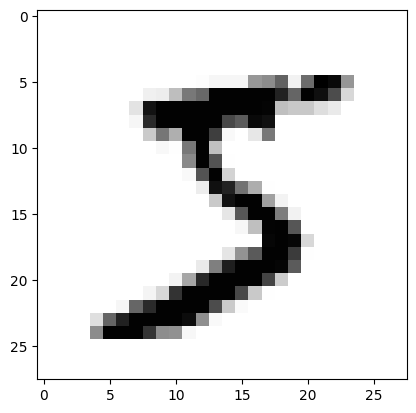

In [25]:
i_image = 0
plt.imshow(X_train[i_image, :, :], cmap="Greys")
plt.show()

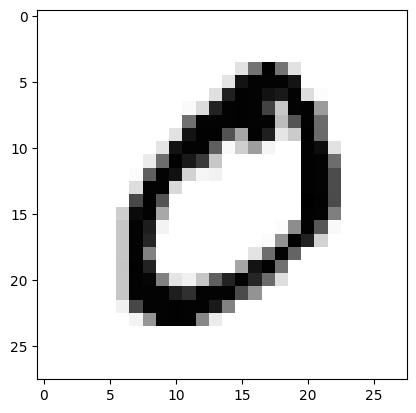

In [26]:
i_image = 1
plt.imshow(X_train[i_image, :, :], cmap="Greys")
plt.show()

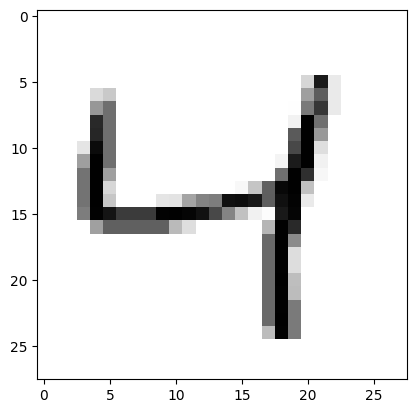

In [27]:
i_image = 2
plt.imshow(X_train[i_image, :, :], cmap="Greys")
plt.show()

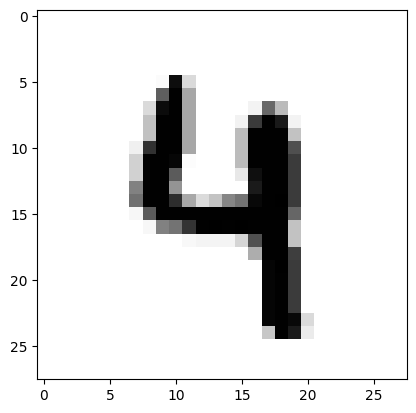

In [28]:
i_image = 50432
plt.imshow(X_train[i_image, :, :], cmap="Greys")
plt.show()

In [29]:
X_train = X_train/255
X_test = X_test/255

In [30]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [32]:
import tensorflow as tf

In [33]:
y = np.concatenate([y_train, y_test], axis=0)
y = tf.keras.utils.to_categorical(y, 10)
y_train = y[:n_train_size, :]
y_test = y[n_train_size:, :]

In [34]:
drop_prob = 0.5
my_model = Sequential()

my_model.add(Conv2D(input_shape=(28,28,1), filters=32, kernel_size=(5, 5), padding='same', activation='relu'))
my_model.add(MaxPooling2D(pool_size=2))

my_model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu'))
my_model.add(MaxPooling2D(pool_size=2))

my_model.add(Flatten())
my_model.add(Dense(units=1024, activation='relu'))

my_model.add(Dropout(rate=drop_prob))

my_model.add(Dense(units=10, activation='softmax'))

In [35]:
my_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     3,212,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,274,634 (12.49 MB)

 Trainable params: 3,274,634 (12.49 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
n_epochs = 10
batch_size = 200
learn_rate = 0.001

In [37]:
my_optimizer=Adam(learning_rate=learn_rate)
my_model.compile(loss="categorical_crossentropy", optimizer=my_optimizer, metrics=["accuracy"])

In [38]:
my_summary = my_model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 133s 547ms/step - accuracy: 0.8489 - loss: 0.4673 - val_accuracy: 0.9835 - val_loss: 0.0554
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 148s 617ms/step - accuracy: 0.9825 - loss: 0.0571 - val_accuracy: 0.9868 - val_loss: 0.0427
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 134s 558ms/step - accuracy: 0.9886 - loss: 0.0359 - val_accuracy: 0.9902 - val_loss: 0.0336
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 143s 563ms/step - accuracy: 0.9904 - loss: 0.0286 - val_accuracy: 0.9905 - val_loss: 0.0304
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 140s 556ms/step - accuracy: 0.9934 - loss: 0.0212 - val_accuracy: 0.9915 - val_loss: 0.0314
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 142s 557ms/step - accuracy: 0.9946 - loss: 0.0164 - val_accuracy: 0.9894 - val_loss: 0.0369
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 148s 616ms/step - accuracy: 0.9955 - loss: 0.0136 - val_accuracy: 0.9910 - val_loss: 0.0324
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 194s 584ms/step - accuracy: 0.9966 -

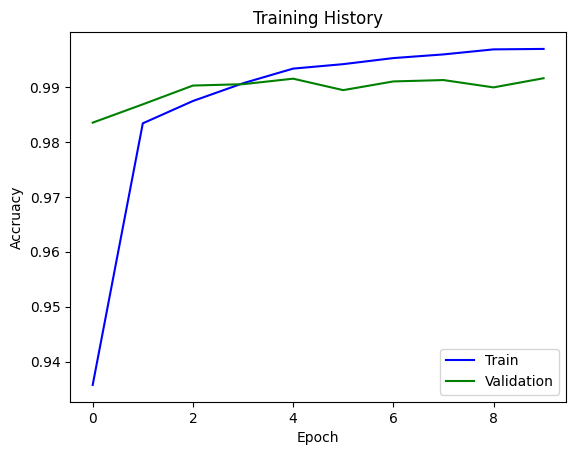

In [39]:
n_skip = 0
plt.plot(my_summary.history['accuracy'][n_skip:], c="b")
plt.plot(my_summary.history['val_accuracy'][n_skip:], c="g")
plt.title('Training History')
plt.ylabel('Accruacy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [40]:
ACC = my_model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy : {}".format(np.round(ACC, 3)))

Test Accuracy : 0.992


Las **redes neuronales convolucionales (CNN)** y las **redes neuronales recurrentes (RNN)** son dos tipos de redes neuronales diseñadas para diferentes tipos de datos y tareas. A continuación, te explico las diferencias entre ambas de forma detallada, cubriendo su propósito, arquitectura, funcionamiento, aplicaciones y relación con el preprocesamiento (como MinMaxScaler, StandardScaler y RobustScaler mencionados previamente).

---

### **1. Propósito y tipo de datos**
- **CNN (Convolutional Neural Networks)**:
  - **Propósito**: Diseñadas para procesar datos estructurados en forma de rejilla, como imágenes (2D) o series temporales (1D). Explotan la estructura espacial para extraer patrones locales (e.g., bordes, texturas, formas).
  - **Datos típicos**: Imágenes (matrices de píxeles), espectrogramas de audio, o datos con estructura espacial.
  - **Ejemplo de tarea**: Clasificación de imágenes, detección de objetos, segmentación semántica.

- **RNN (Recurrent Neural Networks)**:
  - **Propósito**: Diseñadas para datos secuenciales o temporales, donde el orden de los datos importa. Capturan dependencias temporales o secuenciales entre elementos.
  - **Datos típicos**: Series temporales, texto (secuencias de palabras), audio (como señales temporales), o cualquier dato donde los elementos estén ordenados.
  - **Ejemplo de tarea**: Modelado de lenguaje, predicción de series temporales, traducción automática.

**Diferencia clave**: Las CNN se centran en patrones espaciales, mientras que las RNN se centran en dependencias temporales o secuenciales.

---

### **2. Arquitectura**
- **CNN**:
  - **Componentes principales**:
    - **Capas convolucionales**: Aplican filtros para extraer características espaciales (e.g., bordes, formas).
    - **Capas de pooling**: Reducen la dimensionalidad espacial (e.g., max pooling).
    - **Capas completamente conectadas**: Combinan características para la tarea final (e.g., clasificación).
  - **Estructura**: Procesamiento jerárquico de datos en bloques (convolución → activación → pooling), seguido de capas densas.
  - **Conexiones**: Los filtros se comparten entre regiones de la entrada, lo que reduce parámetros y explota la localidad espacial.
  - **Ejemplo**:
    ```
    Entrada (imagen 224x224x3)
    → Conv2D (32 filtros 3x3, ReLU) → MaxPooling (2x2)
    → Conv2D (64 filtros 3x3, ReLU) → MaxPooling (2x2)
    → Flatten → Dense (128, ReLU) → Dense (10, Softmax)
    ```

- **RNN**:
  - **Componentes principales**:
    - **Unidades recurrentes**: Procesan la entrada secuencialmente, manteniendo un estado oculto que captura información de pasos anteriores.
    - **Variantes**: LSTM (Long Short-Term Memory) y GRU (Gated Recurrent Unit) para manejar dependencias a largo plazo.
    - **Capas de salida**: Pueden ser densas para tareas como clasificación o regresión en cada paso temporal.
  - **Estructura**: Procesamiento secuencial, donde cada paso de la secuencia actualiza el estado oculto basado en la entrada actual y el estado anterior.
  - **Conexiones**: Las conexiones recurrentes permiten que la red "recuerde" información de pasos anteriores.
  - **Ejemplo**:
    ```
    Entrada (secuencia de 100 palabras, cada una con embedding de 50 dimensiones)
    → LSTM (128 unidades) → Dense (10, Softmax)
    ```

**Diferencia clave**: Las CNN tienen una estructura jerárquica espacial, mientras que las RNN tienen una estructura secuencial con conexiones recurrentes.

---

### **3. Funcionamiento**
- **CNN**:
  - **Cómo procesa datos**: Aplica filtros convolucionales para extraer características locales, reduciendo progresivamente el tamaño de los datos mediante pooling. Las capas finales combinan estas características para tomar decisiones.
  - **Memoria**: No tiene memoria temporal; cada entrada (e.g., imagen) se procesa de forma independiente.
  - **Invarianza**: Invariante a traslaciones espaciales debido al uso de filtros compartidos.
  - **Entrenamiento**: Usa backpropagation estándar para ajustar los filtros y pesos.

- **RNN**:
  - **Cómo procesa datos**: Procesa la entrada paso a paso, actualizando un estado oculto que captura información previa. Esto permite modelar dependencias temporales o secuenciales.
  - **Memoria**: Tiene memoria a corto y largo plazo (especialmente en LSTM/GRU), lo que le permite "recordar" información de pasos anteriores.
  - **Invarianza**: No es invariante a traslaciones espaciales, pero es sensible al orden de la secuencia.
  - **Entrenamiento**: Usa backpropagation through time (BPTT), que puede ser más complejo debido a problemas como el desvanecimiento/explosión del gradiente.

**Diferencia clave**: Las CNN procesan datos de forma jerárquica y estática, mientras que las RNN procesan datos secuencialmente, manteniendo un estado que evoluciona con el tiempo.

---

### **4. Aplicaciones**
- **CNN**:
  - Clasificación de imágenes (e.g., ImageNet).
  - Detección de objetos (e.g., YOLO, Faster R-CNN).
  - Segmentación semántica (e.g., U-Net).
  - Reconocimiento facial.
  - Procesamiento de datos con estructura espacial, como espectrogramas de audio.

- **RNN**:
  - Modelado de lenguaje (e.g., predicción de la siguiente palabra).
  - Traducción automática (e.g., seq2seq models).
  - Predicción de series temporales (e.g., precios de acciones).
  - Reconocimiento de voz (procesamiento de señales temporales).
  - Generación de texto o música.

**Diferencia clave**: Las CNN son ideales para datos con estructura espacial, mientras que las RNN son mejores para datos secuenciales o temporales.

---

### **5. Ventajas y desventajas**
- **CNN**:
  - **Ventajas**:
    - Eficientes para datos espaciales debido al uso de filtros compartidos.
    - Reducen parámetros mediante pooling y convoluciones.
    - Invariantes a traslaciones espaciales.
  - **Desventajas**:
    - No manejan bien datos secuenciales o dependencias temporales.
    - Requieren grandes cantidades de datos etiquetados para imágenes.
    - Sensibles a rotaciones/escalas sin técnicas adicionales (e.g., data augmentation).

- **RNN**:
  - **Ventajas**:
    - Capturan dependencias temporales y secuenciales.
    - Eficaces para datos donde el orden importa (e.g., texto, series temporales).
    - Variantes como LSTM/GRU manejan dependencias a largo plazo.
  - **Desventajas**:
    - Entrenamiento más lento y propenso a problemas como el desvanecimiento del gradiente.
    - Menos eficientes para datos espaciales.
    - Requieren secuencias bien definidas, lo que puede complicar el preprocesamiento.

---

### **6. Relación con el preprocesamiento (MinMaxScaler, StandardScaler, RobustScaler)**
El preprocesamiento es crucial para ambas arquitecturas, pero se aplica de forma diferente según el tipo de datos:

- **CNN**:
  - **Datos**: Imágenes (valores de píxeles, típicamente 0-255).
  - **Preprocesamiento común**:
    - **MinMaxScaler**: Escala los píxeles a [0, 1] dividiendo entre 255. Es el estándar para imágenes, ya que las CNN funcionan mejor con valores normalizados.
    - **StandardScaler**: Menos común, pero puede usarse si los datos de entrada (e.g., características extraídas) tienen una distribución normal.
    - **RobustScaler**: Útil si las imágenes tienen valores atípicos (e.g., píxeles corruptos), aunque es raro.
  - **Ejemplo**:
    ```python
    X = X / 255.0  # Normalización MinMax para imágenes
    ```

- **RNN**:
  - **Datos**: Secuencias (e.g., series temporales, embeddings de palabras).
  - **Preprocesamiento común**:
    - **StandardScaler**: Muy usado para series temporales, ya que estandariza los datos a media 0 y desviación estándar 1, asumiendo una distribución aproximadamente normal.
    - **MinMaxScaler**: Puede usarse si la tarea requiere valores en un rango específico (e.g., [0, 1] o [-1, 1]).
    - **RobustScaler**: Ideal para series temporales con outliers (e.g., picos en datos financieros).
  - **Ejemplo**:
    ```python
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)  # Estandarización para series temporales
    ```

**Diferencia clave**: En CNN, el preprocesamiento suele centrarse en normalizar píxeles (MinMaxScaler es común). En RNN, el preprocesamiento depende del tipo de secuencia, con StandardScaler o RobustScaler siendo más comunes para series temporales.

---

### **7. Ejemplo práctico**
- **CNN para clasificación de imágenes**:
  - **Tarea**: Clasificar imágenes de gatos y perros.
  - **Datos**: Imágenes RGB de 224x224 píxeles.
  - **Arquitectura**:
    ```python
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')  # Gato o perro
    ])
    ```

- **RNN para predicción de series temporales**:
  - **Tarea**: Predecir el precio de una acción basado en datos históricos.
  - **Datos**: Secuencia de precios diarios (e.g., 100 días).
  - **Arquitectura**:
    ```python
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense

    model = Sequential([
        LSTM(50, input_shape=(100, 1)),  # 100 pasos temporales, 1 característica
        Dense(1)  # Predicción del precio
    ])
    ```

---

### **8. Resumen comparativo**
| **Aspecto**            | **CNN**                                   | **RNN**                                   |
|------------------------|-------------------------------------------|-------------------------------------------|
| **Tipo de datos**      | Estructura espacial (imágenes, rejillas)  | Secuencias (texto, series temporales)     |
| **Arquitectura**       | Convoluciones, pooling, capas densas      | Unidades recurrentes (LSTM, GRU), densas  |
| **Memoria**            | Sin memoria temporal                      | Memoria de pasos anteriores               |
| **Invarianza**         | A traslaciones espaciales                | A orden secuencial                       |
| **Aplicaciones**       | Visión por computadora, imágenes          | Procesamiento de lenguaje, series temporales |
| **Preprocesamiento**   | MinMaxScaler (imágenes)                  | StandardScaler, RobustScaler (secuencias)  |
| **Entrenamiento**      | Backpropagation estándar                 | Backpropagation through time (BPTT)       |

---

### **9. Cuándo usar cada una**
- **Usa CNN** si trabajas con datos espaciales, como imágenes o estructuras en rejilla, y necesitas extraer patrones locales.
- **Usa RNN** si trabajas con datos secuenciales, como texto o series temporales, y necesitas modelar dependencias temporales.

**Nota**: En la práctica, las CNN y RNN a veces se combinan (e.g., CNN para extraer características de imágenes en video, seguido de RNN para modelar la secuencia temporal). También existen arquitecturas modernas como **Transformers**, que han reemplazado a las RNN en muchas tareas secuenciales (e.g., NLP) debido a su mayor eficiencia.



In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, TimeDistributed

from tensorflow.keras.optimizers import Adam, RMSprop, SGD
warnings.filterwarnings('ignore')
%matplotlib inline

In [42]:
df = pd.read_csv('data_time_series.csv', header='infer', encoding='latin1')
n_times_steps = df.shape[0]
print(df.shape)

(41, 1)


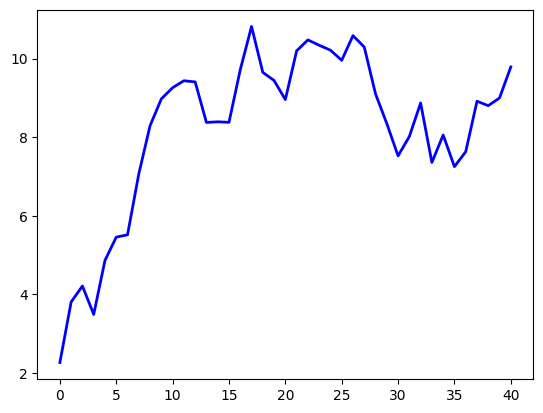

In [43]:
plt.plot(df.Value, c="b", linewidth=2, linestyle="-")
plt.show()

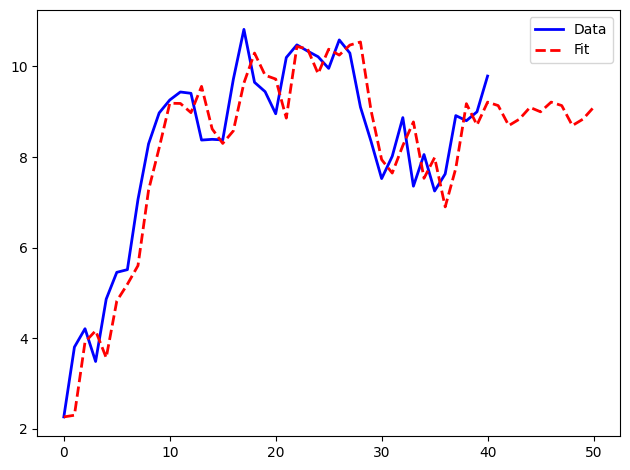

In [44]:
model = ExponentialSmoothing(df['Value'][0:40], seasonal='mul', seasonal_periods=6).fit()
pred = model.predict(start=0, end=50)
plt.plot(df, c='b', linewidth=2, linestyle='-', label='Data')
plt.plot(pred, c='r', linewidth=2, linestyle='--', label='Fit')
plt.legend()
plt.tight_layout()
plt.show()

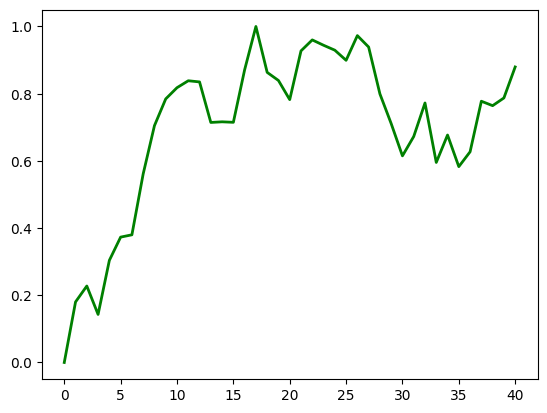

In [45]:
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(df)
plt.plot(ts_scaled, c="g", linewidth=2, linestyle="-")
plt.show()

In [46]:
ts_scaled_2 = ts_scaled.reshape(1, -1, 1)

In [47]:
n_epochs = 1001
batch_size = 1
learn_rate = 0.0002

In [48]:
n_input = 1
n_neurons = 100
n_output = 1

In [49]:
my_model = Sequential()
my_model.add(SimpleRNN(units=n_neurons, return_sequences=True, input_shape=(None, n_input)))

my_model.add(TimeDistributed(Dense(units=n_output, activation="linear")))

In [50]:
my_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, None, 100)      │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 1)        │           101 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,301 (40.24 KB)

 Trainable params: 10,301 (40.24 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
my_optimizer=Adam(learning_rate=learn_rate)
my_model.compile(loss="mse", optimizer=my_optimizer, metrics=["mse"])

In [52]:
my_summary = my_model.fit(ts_scaled_2[:, :-1, :], ts_scaled_2[:, 1:, :], epochs=n_epochs,
                          batch_size=batch_size, verbose=0)

In [53]:
my_summary.history.keys()

dict_keys(['loss', 'mse'])

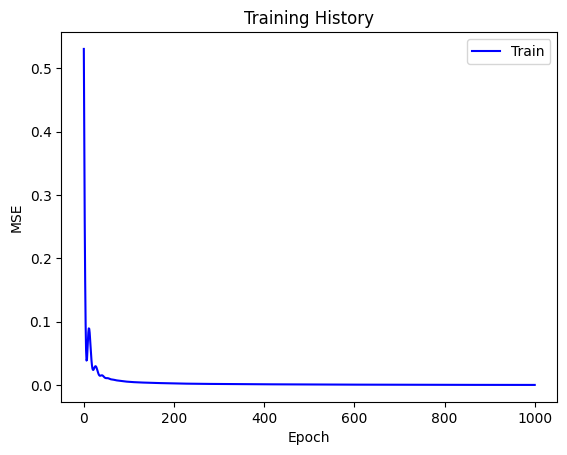

In [54]:
plt.plot(my_summary.history['mse'], c="b")
plt.title('Training History')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [55]:
n_ts_seed = 5
n_predict_time_steps = 55

In [56]:
ts_seed = ts_scaled[0:n_ts_seed]
for i in range(n_predict_time_steps):
    X = ts_seed.reshape(1, -1, 1)
    y_pred = my_model.predict(X, verbose=0)
    y_last = y_pred[0, -1, 0]
    ts_seed = np.concatenate((ts_seed, np.array([y_last]).reshape(1, 1)), axis=0)

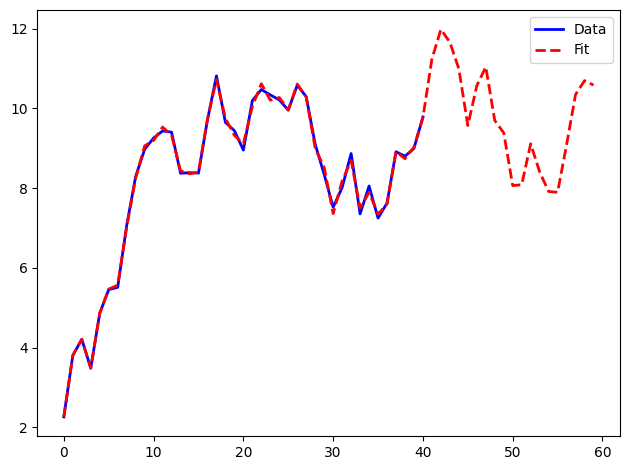

In [57]:
ts = scaler.inverse_transform(ts_seed)
plt.plot(df.Value, c='b', linewidth=2, linestyle="-", label="Data")
plt.plot(ts, c='r', linewidth=2, linestyle="--", label="Fit")
plt.legend()
plt.tight_layout()
plt.savefig("out.png")
plt.show()

# Ejercicio de cierre de CAP 8


Respuesta en https://github.com/davidlealo/sic_ai_2025_jun/blob/main/05deeplearning/clase_39.ipynb

## Caso de estudio


El presente ejercicio vi su solicón en un curso que les recomiendo de Platzi: https://platzi.com/cursos/deeplearning

In [58]:
# Instalar las librerías para trabajar directamente con Kaggle

!pip install --upgrade --force-reinstall --no-deps kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.5
    Uninstalling kaggle-1.7.4.5:
      Successfully uninstalled kaggle-1.7.4.5


In [63]:
# Posterior a subir el json de kaggle la idea es localizar el archivo en la configuración necesaria

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [64]:
!kaggle models list

Next Page Token = CfDJ8IaGWDgvvrBFtGGva9hUIY4sD97NM1e8_rLyPKRsSA5gLRT3qw_gFcc16PIJv2GRlYU_m43D2jtUmjzF2hl-Vk8
    id  ref                                      title                      subtitle                                                                                                                                                                                                                                     author             
------  ---------------------------------------  -------------------------  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------  -----------------  
456721  qwen-lm/qwen-3-vl                        Qwen 3 VL                  Qwen3-VL is the most powerful vision-language model in its series, offering significant upgrades in visual perception, reasoning, and context unders

In [65]:
# Cargar el listado de los datasets de telecomunicaciones

!kaggle datasets list -s telco-customer-churn

ref                                                              title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
blastchar/telco-customer-churn                                   Telco Customer Churn                                    175758  2018-02-23 18:20:00.210000         439027       3253  0.88235295       
abdallahwagih/telco-customer-churn                               Telco Customer Churn                                   1314646  2024-10-11 05:27:55.330000           2788         56  0.88235295       
alfathterry/telco-customer-churn-11-1-3                          Telco customer churn (11.1.3+)                          525781  2024-05-08 20:46:56.010000           4217         59  1.0          

# Explicación del comando

El comando que analizamos es:

```bash
!kaggle datasets download -d blastchar/telco-customer-churn
```

---

## 1️⃣ `!`

* En **Jupyter Notebook** o **Colab**, el símbolo `!` se utiliza para ejecutar **comandos de terminal** directamente desde una celda de Python.
* Sin el `!`, Python trataría de interpretar todo como código Python, y fallaría.

Ejemplo:

```python
!ls
```

Lista los archivos del directorio actual.

---

## 2️⃣ `kaggle`

* Es el comando que invoca la **Kaggle CLI (Command Line Interface)**.
* Permite interactuar con Kaggle desde la terminal: descargar datasets, participar en competiciones, subir notebooks, etc.
* Para usarlo necesitas:

  * Tener instalada la librería `kaggle` en Python (`pip install kaggle`).
  * Tener un archivo `kaggle.json` con tus credenciales en la carpeta `~/.kaggle/` o `/root/.kaggle/` en Colab.

---

## 3️⃣ `datasets`

* Este subcomando indica que quieres **trabajar con datasets** de Kaggle.
* Otros subcomandos posibles: `competitions`, `kernels`, etc.

---

## 4️⃣ `download`

* Acción que le dices a Kaggle: **descargar un dataset**.
* Equivalente a pulsar "Download" en la página web de Kaggle.

---

## 5️⃣ `-d blastchar/telco-customer-churn`

* La opción `-d` indica **dataset** y se le pasa el **identificador del dataset**.

* `blastchar/telco-customer-churn` es el nombre único de ese dataset en Kaggle:

  * `blastchar` → usuario o propietario del dataset.
  * `telco-customer-churn` → nombre del dataset específico.

* Esto le dice a Kaggle CLI exactamente **qué dataset descargar**.

---

## ⚡ Resumen práctico

Esta línea le indica a Colab o Jupyter:

> “Ejecuta el comando de terminal `kaggle`, y usa la API para descargar el dataset `telco-customer-churn` del usuario `blastchar`”.


In [66]:
# Descargar el dataset del ejercicio que busca predecir si una persona va a dar de baja su servicio telefónico

!kaggle datasets download -d blastchar/telco-customer-churn

Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
License(s): copyright-authors
  0% 0.00/172k [00:00<?, ?B/s]
100% 172k/172k [00:00<00:00, 338MB/s]


In [67]:
# Descomprimir el archivo

!unzip '/content/telco-customer-churn.zip'

Archive:  /content/telco-customer-churn.zip
  inflating: WA_Fn-UseC_-Telco-Customer-Churn.csv  


1. customerID (object)

> Identificador único para cada cliente. No tiene valor predictivo, sirve solo para distinguir registros.


2. gender (object)

> Género del cliente: “Male” (hombre) o “Female” (mujer).


3. SeniorCitizen (int64)

> Indica si el cliente es adulto mayor: 1 = sí, 0 = no.


4. Partner (object)

> Indica si el cliente tiene pareja: “Yes” = sí, “No” = no.


5. Dependents (object)

> Indica si el cliente tiene personas dependientes a su cargo: “Yes” = sí, “No” = no.


6. tenure (int64)

> Cantidad de meses que el cliente ha estado con la compañía. Es útil para medir fidelidad.

7. PhoneService (object)

> Indica si el cliente tiene servicio telefónico contratado:
> “Yes” = sí, “No” = no.


8. MultipleLines (object)

> Indica si el cliente tiene múltiples líneas telefónicas:

> “Yes” = sí,

> “No” = no,

> “No phone service” = no tiene servicio telefónico.


9. InternetService (object)

> Tipo de servicio de Internet contratado:

> “DSL”

> “Fiber optic”

> “No” = no tiene servicio de Internet.

10. OnlineSecurity (object)

> Indica si el cliente tiene servicio de seguridad en línea:

> “Yes” = sí,

> “No” = no,

> “No internet service” = no tiene servicio de Internet.

11. OnlineBackup (object)

> Servicio de respaldo en línea: “Yes”, “No”, o “No internet service”.

12. DeviceProtection (object)

> Protección de dispositivos del cliente: “Yes”, “No”, o “No internet service”.

13. TechSupport (object)

> Servicio de soporte técnico: “Yes”, “No”, o “No internet service”.

14. StreamingTV (object)

> Servicio de streaming de TV: “Yes”, “No”, o “No internet service”.

15. StreamingMovies (object)

> Servicio de streaming de películas: “Yes”, “No”, o “No internet service”.

16. Contract (object)

> Tipo de contrato del cliente:

> “Month-to-month” = mensual,

> “One year” = anual,

> “Two year” = contrato de dos años.

17. PaperlessBilling (object)

> Indica si el cliente recibe facturación electrónica: “Yes” = sí, “No” = no.

18. PaymentMethod (object)

> Método de pago del cliente:

> “Electronic check” = cheque electrónico,

> “Mailed check” = cheque físico,

> “Bank transfer (automatic)” = transferencia bancaria automática,

> “Credit card (automatic)” = tarjeta de crédito automática.

19. MonthlyCharges (float64)

> Monto mensual que paga el cliente en dólares.

20. TotalCharges (object)

> Monto total pagado por el cliente durante toda su permanencia (tenure). Aunque parece numérico, está como objeto, por lo que hay que convertirlo a float para análisis.

21. Churn (object)

> Indica si el cliente dejó la compañía:

> “Yes” = abandonó (churn),

> “No” = sigue activo.